In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
plt.rcParams["figure.dpi"] = 150

In [26]:
world_avg_inflation = {
    2018: 2.4503624385017,
    2019: 2.20607305781525,
    2020: 1.93694126694223,
    2021: 3.44527766461135,
    2022: 7.98518671835033,
    2023: 5.80113321465538
}

def fill_inflation(row):
    if pd.isna(row['inflation']):
        return world_avg_inflation.get(row['year'], row['inflation'])
    else:
        return row['inflation']

def correct_name(row):
    if country_dict.get(row['Country Code']):
        return country_dict.get(row['Country Code'])
    return row['country']


def correct_rate(row):
    if row["vacc_rate"] > 100:
        return 100
    return row["vacc_rate"]

### Trade Data

In [27]:
trade_data = pd.read_excel("TradeData.xlsx")
country_dict = dict(zip(trade_data['PartnerISO'], trade_data['PartnerDesc']))

all_trade_value = trade_data.pivot_table(index=['RefYear', 'PartnerDesc'], columns='CmdDesc', values='Fobvalue', aggfunc='sum').reset_index()
all_trade_value = all_trade_value.rename(columns={'RefYear': 'year', 'PartnerDesc': 'country'})
all_trade_value.fillna(1, inplace=True)
all_trade_value['all_trade'] = all_trade_value.drop(columns=['year', 'country']).sum(axis=1)
all_trade_value.rename_axis(columns=None, inplace=True)
all_trade_value.rename(columns={"Dairy produce; birds' eggs; natural honey; edible products of animal origin, not elsewhere specified or included": "dairy_produce", "Fish and crustaceans, molluscs and other aquatic invertebrates": "aquatic_produce", "Fruit and nuts, edible; peel of citrus fruit or melons": "fruit_produce", "Meat and edible meat offal": "meat_produce", "Vegetables and certain roots and tubers; edible": "vegetable_produce"}, inplace=True)
all_trade_value.head()

,year,country,dairy_produce,aquatic_produce,fruit_produce,meat_produce,vegetable_produce,all_trade
0,2018,Afghanistan,8.361214e+05,1.000,236927.298,1.000,1.000,1.073052e+06
1,2018,Albania,1.000000e+00,59293.495,1.000,1.000,1.000,5.929750e+04
2,2018,Algeria,3.376288e+08,1.000,1.000,1.000,2355259.980,3.399841e+08
3,2018,American Samoa,9.998871e+05,134176.390,774.689,1527830.591,133002.577,2.795671e+06
4,2018,Angola,4.156789e+06,864837.577,1.000,1.000,1.000,5.021630e+06


### GDP

In [28]:
overall_gdp = pd.read_excel("GDP.xlsx",sheet_name="overall_gdp").drop(columns="Unnamed: 1")
average_gdp = pd.read_excel("GDP.xlsx",sheet_name="average_gdp").drop(columns="Unnamed: 1")
overall_gdp = overall_gdp.melt(id_vars=["Country Name"], var_name="Year", value_name="GDP")
average_gdp = average_gdp.melt(id_vars=["Country Name"], var_name="Year", value_name="avg_GDP")
overall_gdp = overall_gdp.rename(columns={"Country Name": "country", "Year": "year"})
average_gdp = average_gdp.rename(columns={"Country Name": "country", "Year": "year"})
overall_gdp.year = overall_gdp.year.astype(int)
average_gdp.year = average_gdp.year.astype(int)

In [29]:
overall_gdp.head()

,country,year,GDP
0,Aruba,2018,3.276184e+09
1,Afghanistan,2018,1.805322e+10
2,Angola,2018,7.945069e+10
3,Albania,2018,1.515642e+10
4,United Arab Emirates,2018,4.270494e+11


In [30]:
average_gdp.head()

,country,year,avg_GDP
0,Aruba,2018,30918.483584
1,Afghanistan,2018,492.090631
2,Angola,2018,2540.508879
3,Albania,2018,5287.660801
4,United Arab Emirates,2018,46722.268719


### FTA

In [31]:
fta = pd.read_excel("FTA.xlsx").drop(columns="Unnamed: 0")
fta = fta.melt(id_vars=["年份"], var_name="Year", value_name="FTA")
fta = fta.rename(columns={"年份": "country", "Year": "year"})
fta.year = fta.year.astype(int)
fta.head()

,country,year,FTA
0,Aruba,2018,0
1,Afghanistan,2018,0
2,Angola,2018,0
3,Albania,2018,0
4,United Arab Emirates,2018,0


### Freight

In [32]:
freight = pd.read_excel("Freight.xlsx")
freight.replace(0, np.nan, inplace=True)
freight.update(freight.iloc[:, 1:-1].apply(lambda x: x.fillna(x.mean()), axis=0))
freight['country'] = freight.apply(correct_name, axis=1)
freight = freight.drop(columns="Country Code")
freight = freight.melt(id_vars=["country"], var_name="Year", value_name="Freight")
freight = freight.rename(columns={"Year": "year", "Freight": "freight"})
freight.year = freight.year.astype(int)
freight.head()

,country,year,freight
0,Afghanistan,2018,29.167851
1,Albania,2018,8.554160
2,Algeria,2018,21.337823
3,American Samoa,2018,21.337823
4,Angola,2018,4.421110


### Inflation

In [33]:
inflation = pd.read_excel("Inflation.xlsx")[["Country Name", "Time", "Inflation, consumer prices (annual %) [FP.CPI.TOTL.ZG]", "Country Code"]]
inflation = inflation.rename(columns={"Time": "year", "Inflation, consumer prices (annual %) [FP.CPI.TOTL.ZG]": "inflation", "Country Name": "country"})
inflation.replace("..", np.nan, inplace=True)
inflation['inflation'] = inflation.apply(fill_inflation, axis=1)
inflation['country'] = inflation.apply(correct_name, axis=1)
inflation.head()

,country,year,inflation,Country Code
0,Afghanistan,2018,0.626149,AFG
1,Afghanistan,2019,2.302373,AFG
2,Afghanistan,2020,1.936941,AFG
3,Afghanistan,2021,3.445278,AFG
4,Afghanistan,2022,7.985187,AFG


### vaccinated rate

In [34]:
covid_vacc = pd.read_excel("vaccinated_rates.xlsx")
covid_vacc[2018] = 0
covid_vacc[2019] = 0
covid_vacc[2020] = covid_vacc[2019] + covid_vacc[2020]
covid_vacc[2021] = covid_vacc[2020] + covid_vacc[2021]
covid_vacc[2022] = covid_vacc[2021] + covid_vacc[2022]
covid_vacc[2023] = covid_vacc[2022] + covid_vacc[2023]
covid_vacc.drop(columns="总计", inplace=True)
covid_vacc.replace(np.nan, 0, inplace=True)
covid_vacc = covid_vacc.melt(id_vars=["location"], var_name="year", value_name="vacc_rate")
covid_vacc = covid_vacc.rename(columns={"location": "country"})
covid_vacc["vacc_rate"] = covid_vacc.apply(correct_rate, axis=1)
covid_vacc.year = covid_vacc.year.astype(int)
covid_vacc.head()

,country,year,vacc_rate
0,Afghanistan,2020,0.0
1,Albania,2020,0.0
2,Algeria,2020,0.0
3,American Samoa,2020,0.0
4,Angola,2020,0.0


### Covid death rate

In [35]:
covid_death_rate= pd.read_excel("covid_death_rate.xls",sheet_name="covid_death_rate")[["Year", "Country", "death rate"]]
covid_death_rate = covid_death_rate.rename(columns={"Country": "country", "Year": "year", "death rate": "death_rate"})
countries = covid_death_rate['country'].unique()

covid_death_rate.head()

,year,country,death_rate
0,2020,Aruba,0.000441
1,2021,Aruba,0.001700
2,2022,Aruba,0.002630
3,2023,Aruba,0.002750
4,2020,Afghanistan,0.000055


### Continent

In [36]:
continent = pd.read_excel("continent.xlsx")
continent.head(10)
continent = continent[["Year", "Country","Asia", "Africa", "North_America", "South_America", "Europe", "Oceania"]]
continent = continent.rename(columns={"Year": "year", "Country": "country"})
continent.replace(np.nan, 0)
continent.head()

,year,country,Asia,Africa,North_America,South_America,Europe,Oceania
0,2018,Afghanistan,1,0,0,0,0,0
1,2018,Albania,0,0,0,0,1,0
2,2018,Algeria,0,1,0,0,0,0
3,2018,American Samoa,0,0,0,0,0,1
4,2018,Angola,0,1,0,0,0,0


### Combine All Data

In [37]:
final_data = all_trade_value.merge(overall_gdp, on=['country', 'year'], how='outer')
final_data = final_data.merge(average_gdp, on=['country', 'year'], how='outer')
final_data = final_data.merge(covid_vacc, on=['country', 'year'], how='outer')
final_data = final_data.merge(freight, on=['country', 'year'], how='outer')
final_data = final_data.merge(inflation, on=['country', 'year'], how='outer')
final_data = final_data.merge(covid_death_rate, on=['country', 'year'], how='outer')
final_data = final_data.merge(fta, on=['country', 'year'], how='outer')
final_data = final_data.merge(continent, on=['country', 'year'], how='outer')
final_data.to_csv('all_data.csv', index=False)
final_data.drop(["Country Code"], axis=1, inplace=True)
final_data.head()

,year,country,dairy_produce,aquatic_produce,fruit_produce,meat_produce,vegetable_produce,all_trade,GDP,avg_GDP,...,freight,inflation,death_rate,FTA,Asia,Africa,North_America,South_America,Europe,Oceania
0,2018,Afghanistan,8.361214e+05,1.000,236927.298,1.000,1.000,1.073052e+06,1.805322e+10,492.090631,...,29.167851,0.626149,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2018,Albania,1.000000e+00,59293.495,1.000,1.000,1.000,5.929750e+04,1.515642e+10,5287.660801,...,8.554160,2.028060,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2018,Algeria,3.376288e+08,1.000,1.000,1.000,2355259.980,3.399841e+08,1.945545e+11,4640.314145,...,21.337823,4.269990,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2018,American Samoa,9.998871e+05,134176.390,774.689,1527830.591,133002.577,2.795671e+06,6.390000e+08,13195.935900,...,21.337823,2.450362,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,2018,Angola,4.156789e+06,864837.577,1.000,1.000,1.000,5.021630e+06,7.945069e+10,2540.508879,...,4.421110,19.628938,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [38]:
def pandemic(row):
    if row['year'] in [2020, 2021, 2022]:
        return 1
    return 0

final_data["death_rate"].replace(np.nan, 0, inplace=True)
final_data.all_trade = np.log(final_data.all_trade)
final_data.dairy_produce = np.log(final_data.dairy_produce)
final_data.aquatic_produce = np.log(final_data.aquatic_produce)
final_data.fruit_produce = np.log(final_data.fruit_produce)
final_data.meat_produce = np.log(final_data.meat_produce)
final_data.vegetable_produce = np.log(final_data.vegetable_produce)
final_data.GDP = np.log(final_data.GDP)
final_data.avg_GDP = np.log(final_data.avg_GDP)
final_data['pandemic'] = final_data.apply(pandemic, axis=1)
final_data.head(10)

,year,country,dairy_produce,aquatic_produce,fruit_produce,meat_produce,vegetable_produce,all_trade,GDP,avg_GDP,...,inflation,death_rate,FTA,Asia,Africa,North_America,South_America,Europe,Oceania,pandemic
0,2018,Afghanistan,13.636529,0.000000,12.375509,0.000000,0.000000,13.886017,23.616590,6.198663,...,0.626149,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
1,2018,Albania,0.000000,10.990255,0.000000,0.000000,0.000000,10.990322,23.441690,8.573131,...,2.028060,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,2018,Algeria,19.637458,0.000000,0.000000,0.000000,14.672162,19.644409,25.993978,8.442537,...,4.269990,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
3,2018,American Samoa,13.815398,11.806911,6.652462,14.239359,11.798124,14.843583,20.275415,9.487664,...,2.450362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
4,2018,Angola,15.240254,13.670297,0.000000,0.000000,0.000000,15.429265,25.098402,7.840120,...,19.628938,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
5,2018,Antigua and Barbuda,13.212250,0.000000,0.000000,11.943985,0.000000,13.460145,21.231004,9.805534,...,1.207158,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
6,2018,Argentina,0.000000,0.000000,12.602414,0.000000,8.296880,12.615828,26.986321,9.375445,...,2.450362,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
7,2018,Armenia,14.940062,0.000000,0.000000,0.000000,0.000000,14.940063,23.245624,8.387523,...,2.520234,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0
8,2018,Aruba,13.741093,0.000000,0.000000,0.000000,0.000000,13.741097,21.909945,10.339109,...,3.626041,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
9,2018,Australia,20.149036,18.794011,18.586107,17.234424,17.755997,20.627156,27.988509,10.955594,...,1.911401,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0


### Data Analysis

## Summary (Mean, Median, Std, Min, Max)

In [39]:
summary_stats = final_data.drop(columns=["pandemic", "country", "FTA"]).groupby('year').agg(['sum','mean', 'median', 'std', 'min', 'max'])
summary_stats.to_csv("trade_data_summary.csv")
summary_stats

dairy_produce                                                  \
               sum       mean     median       std  min        max   
year                                                                 
2018   2309.015121  12.971995  14.532099  5.976799  0.0  21.840783   
2019   2226.839164  12.652495  14.418732  6.168632  0.0  21.981729   
2020   2202.036470  12.583066  13.902223  6.155841  0.0  22.004854   
2021   2230.447570  12.967718  14.051768  5.674132  0.0  22.369588   
2022   2175.076780  12.645795  14.362823  6.350204  0.0  22.163634   
2023   2139.382497  12.584603  14.419767  6.351664  0.0  22.048982   

     aquatic_produce                                 ... Europe            \
                 sum      mean     median       std  ... median       std   
year                                                 ...                    
2018     1487.680806  8.357757  11.355415  6.859790  ...    0.0  0.412147   
2019     1491.746078  8.475830  11.390328  6.800564  ...    0.0  0.412147   
2020     1441.334540  8.236197  11.291542  6.890438  ...    0.0  0.412147   
2021     1469.563467  8.543974  11.244665  6.755031  ...    0.0  0.412147   
2022     1392.126725  8.093760  10.969674  6.905474  ...    0.0  0.412147   
2023     1416.892660  8.334663  11.603215  6.951629  ...    0.0  0.412147   

               Oceania                                       
      min  max     sum      mean median       std  min  max  
year                                                         
2018  0.0  1.0    24.0  0.123077    0.0  0.329371  0.0  1.0  
2019  0.0  1.0    24.0  0.123077    0.0  0.329371  0.0  1.0  
2020  0.0  1.0    24.0  0.123077    0.0  0.329371  0.0  1.0  
2021  0.0  1.0    24.0  0.123077    0.0  0.329371  0.0  1.0  
2022  0.0  1.0    24.0  0.123077    0.0  0.329371  0.0  1.0  
2023  0.0  1.0    24.0  0.123077    0.0  0.329371  0.0  1.0  

[6 rows x 108 columns]

## Correlation matrix

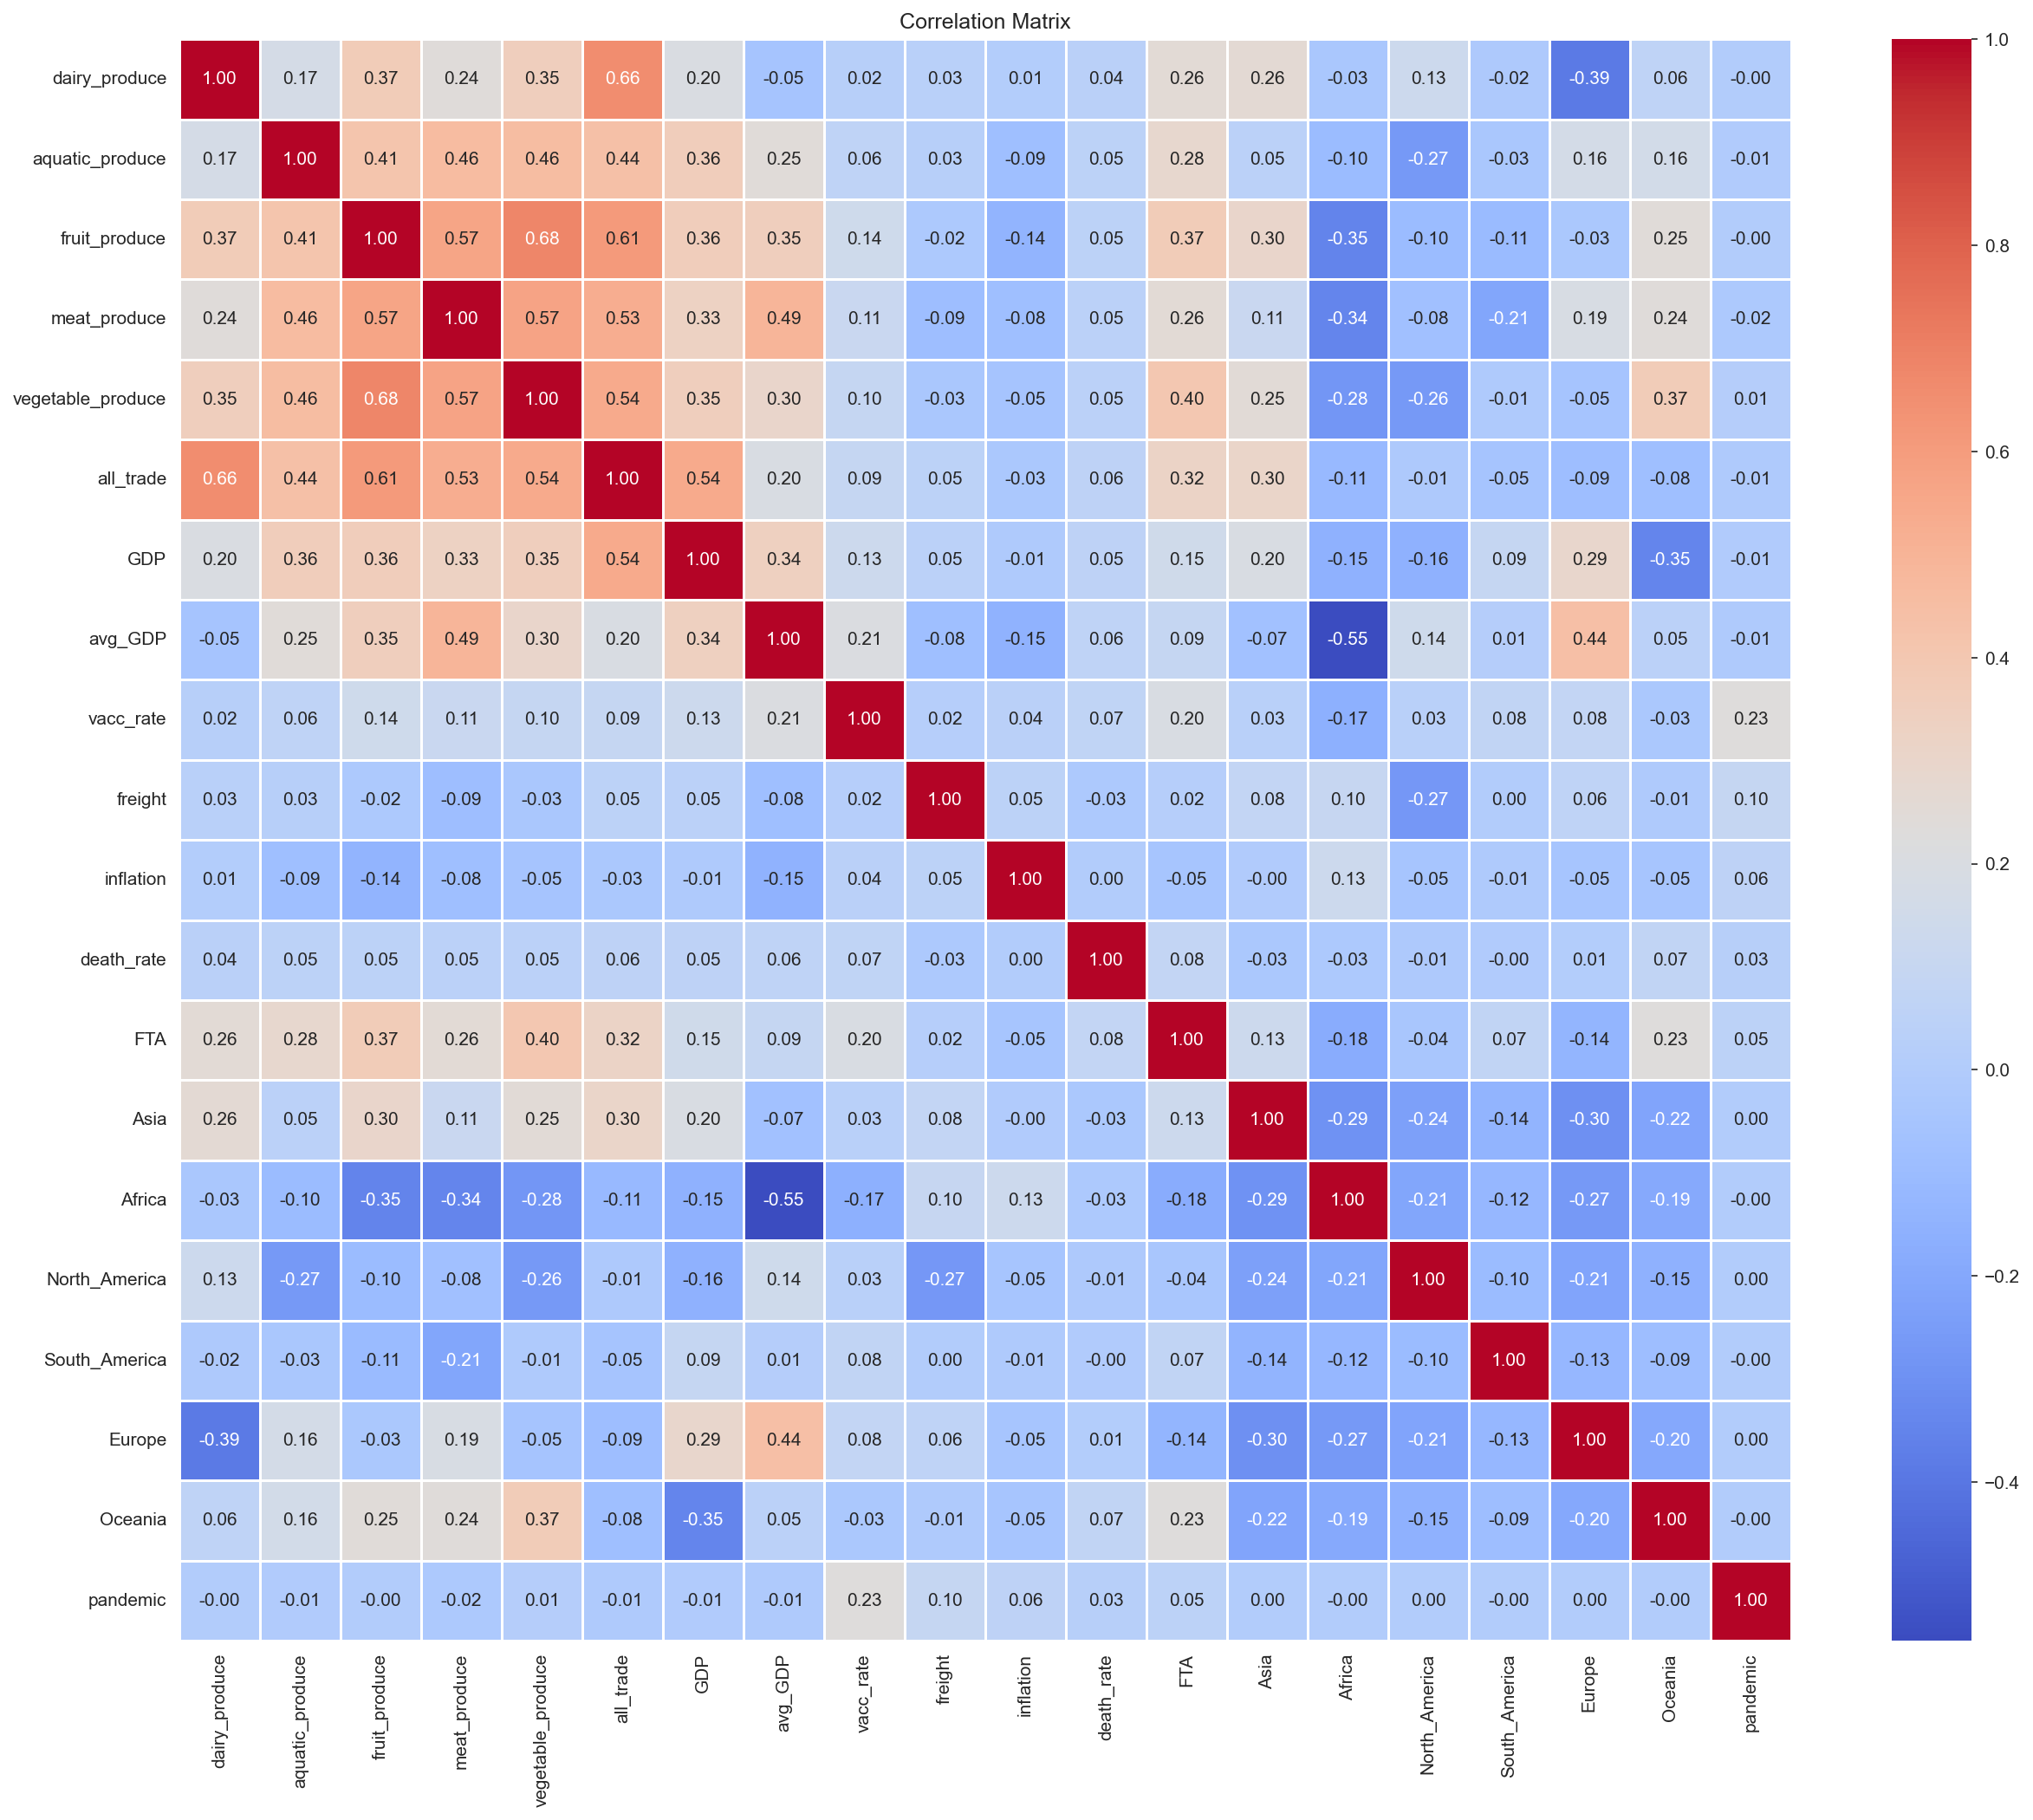

In [40]:
correlation_df = final_data.drop(columns=['year', 'country'])
corr_matrix = correlation_df.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Data Distribution

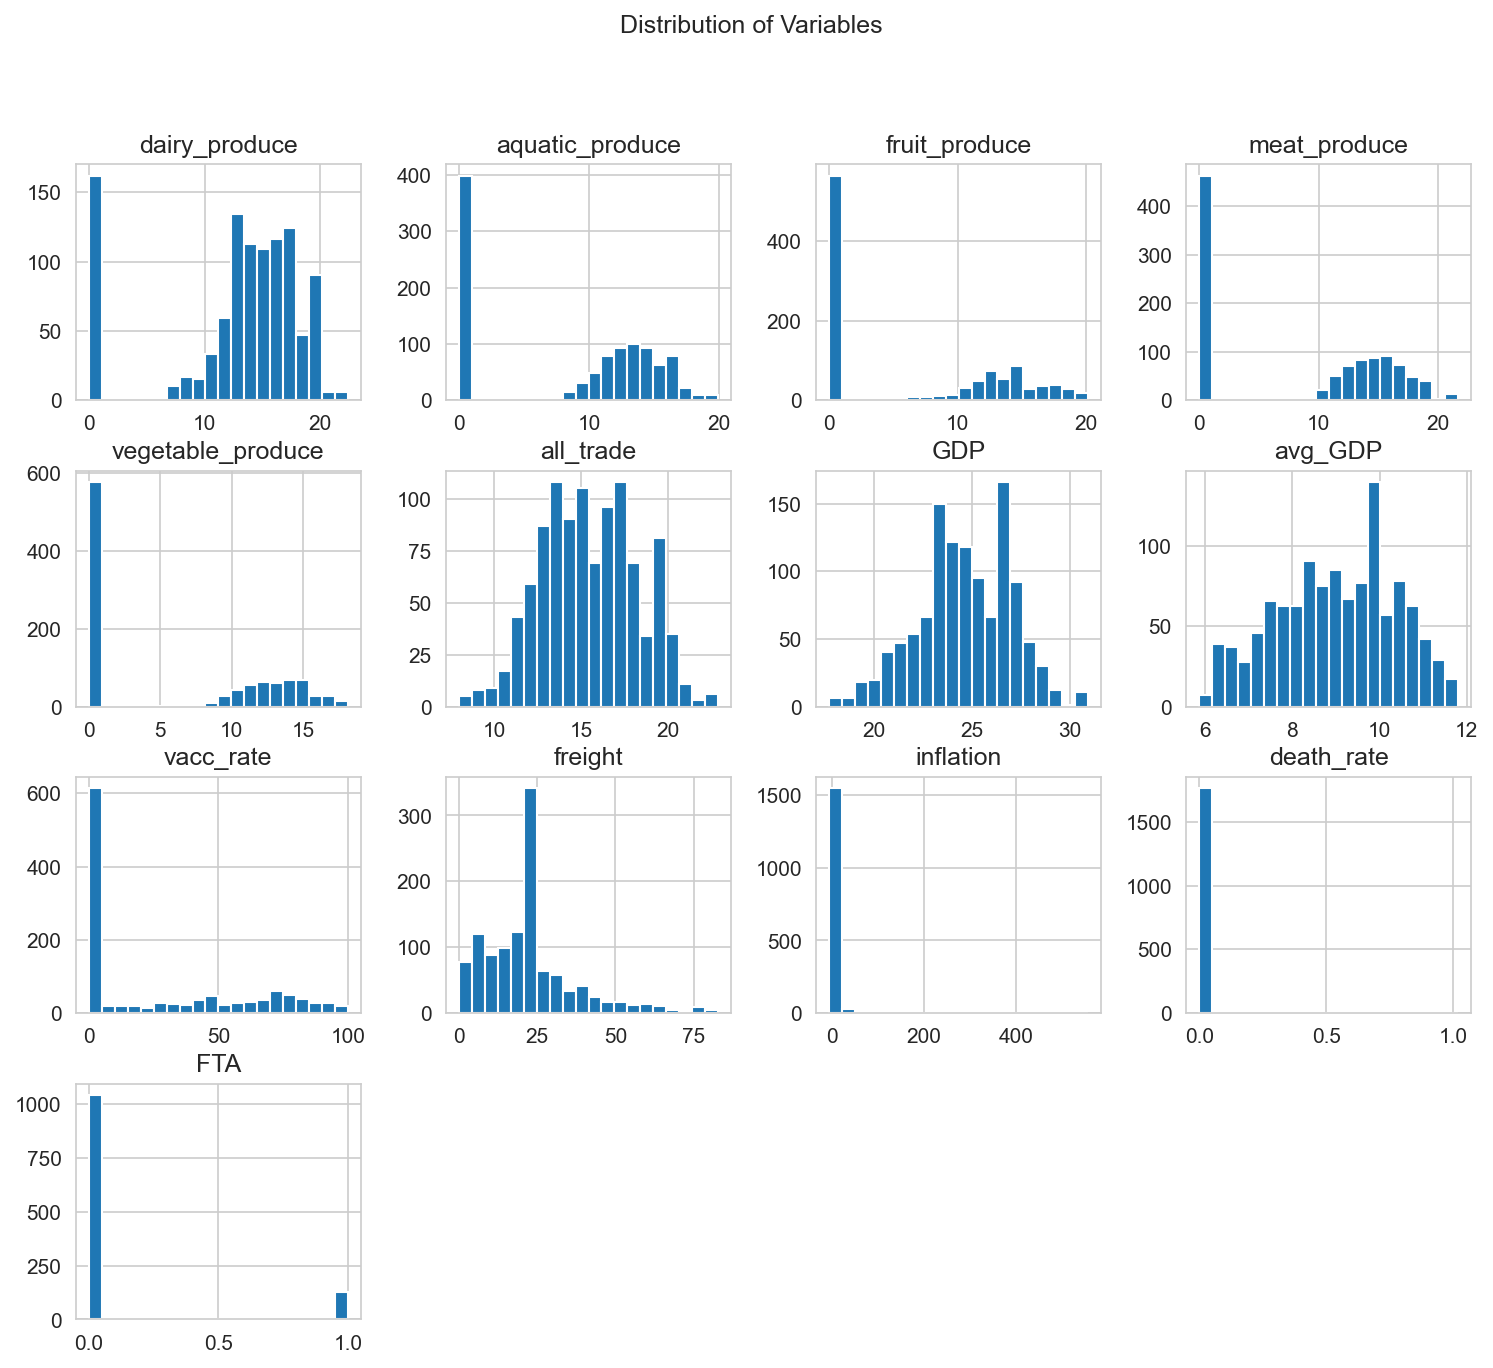

In [41]:
distribution_df = final_data.drop(columns=['year', 'country', 'pandemic', 'Asia', 'Africa', 'North_America', 'South_America', 'Europe', 'Oceania'])
distribution_df.hist(bins=20, figsize=(12, 10))
plt.suptitle('Distribution of Variables')
plt.show()

### Time Series Plot

/var/folders/_t/5xwcj3s913b6rjc1d1nq30m80000gn/T/ipykernel_4175/2896274271.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  final_data.groupby('year').sum().drop(columns=['pandemic', 'FTA', 'Asia', 'Africa', 'North_America', 'South_America', 'Europe', 'Oceania']).plot(subplots=True, figsize=(20, 15), layout=(4, 4), sharex=False)


array([[<AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>,
        <AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>],
       [<AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>,
        <AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>],
       [<AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>,
        <AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>],
       [<AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>,
        <AxesSubplot: xlabel='year'>, <AxesSubplot: xlabel='year'>]],
      dtype=object)

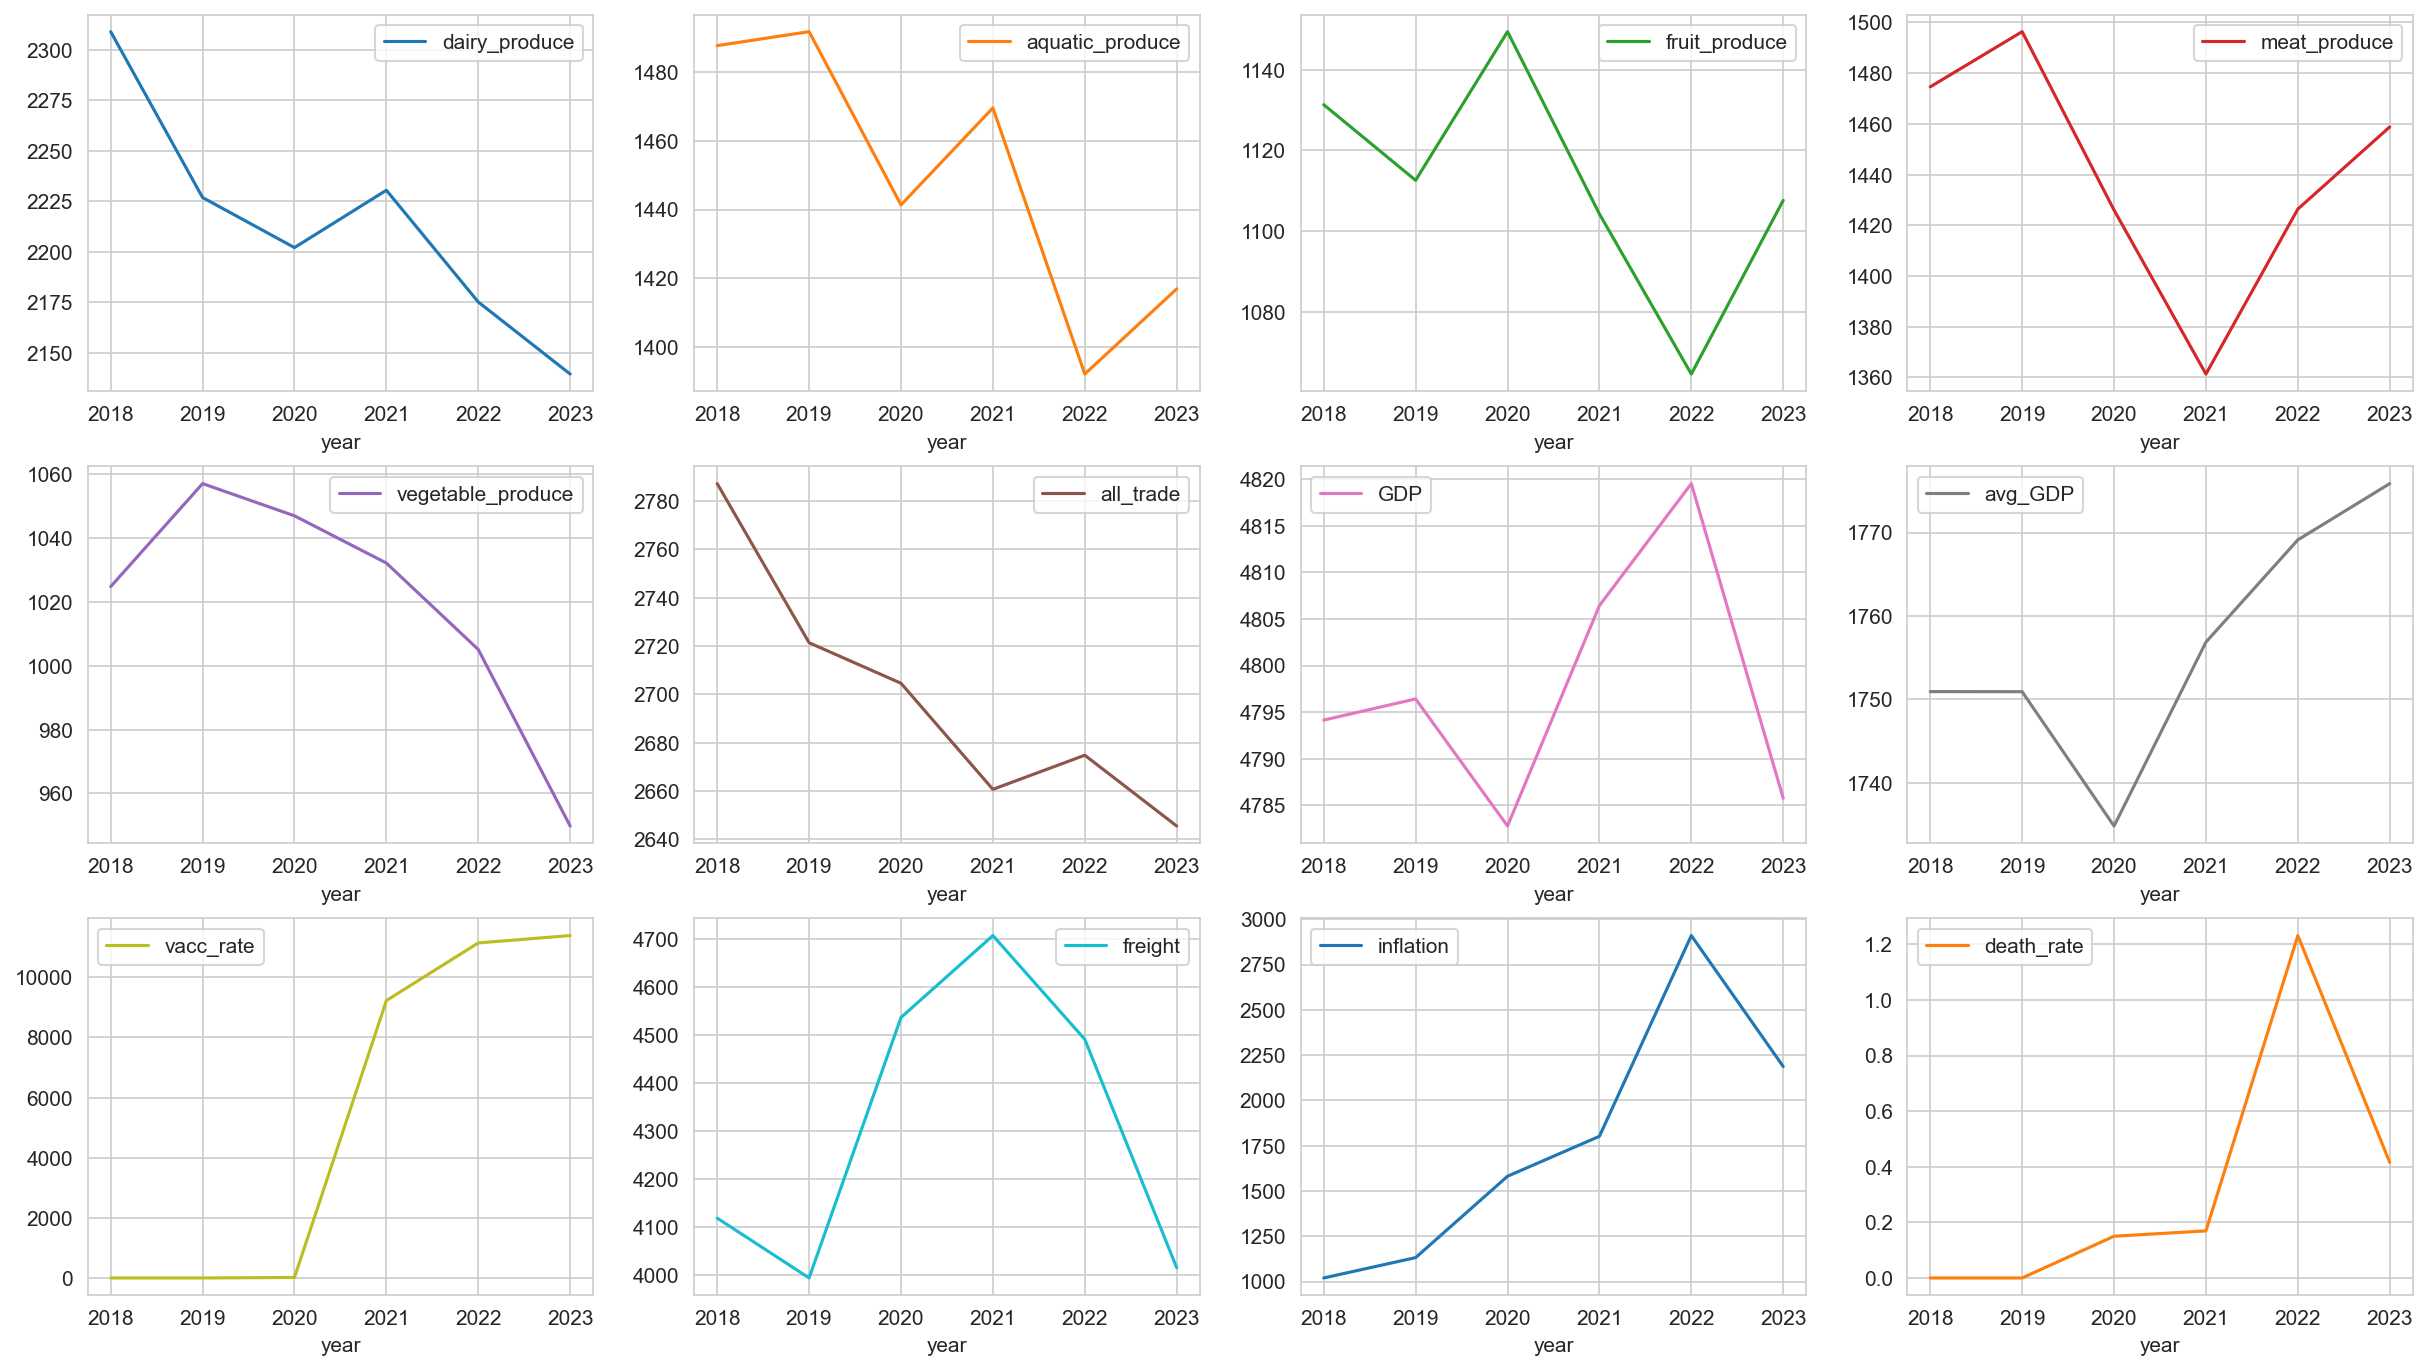

In [42]:
final_data.groupby('year').sum().drop(columns=['pandemic', 'FTA', 'Asia', 'Africa', 'North_America', 'South_America', 'Europe', 'Oceania']).plot(subplots=True, figsize=(20, 15), layout=(4, 4), sharex=False)

### Regression
#### Add polynomial

In [43]:
final_data["pandemic * FTA"] = final_data['pandemic'] * final_data['FTA']
final_data.head()

,year,country,dairy_produce,aquatic_produce,fruit_produce,meat_produce,vegetable_produce,all_trade,GDP,avg_GDP,...,death_rate,FTA,Asia,Africa,North_America,South_America,Europe,Oceania,pandemic,pandemic * FTA
0,2018,Afghanistan,13.636529,0.000000,12.375509,0.000000,0.000000,13.886017,23.616590,6.198663,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0
1,2018,Albania,0.000000,10.990255,0.000000,0.000000,0.000000,10.990322,23.441690,8.573131,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0
2,2018,Algeria,19.637458,0.000000,0.000000,0.000000,14.672162,19.644409,25.993978,8.442537,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0
3,2018,American Samoa,13.815398,11.806911,6.652462,14.239359,11.798124,14.843583,20.275415,9.487664,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0.0
4,2018,Angola,15.240254,13.670297,0.000000,0.000000,0.000000,15.429265,25.098402,7.840120,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0


#### Multicollinearity analysis

In [44]:
targets = list(all_trade_value.columns)[2:]
targets

['dairy_produce',
 'aquatic_produce',
 'fruit_produce',
 'meat_produce',
 'vegetable_produce',
 'all_trade']

In [45]:
final_data = final_data.dropna()

X_collinear = final_data.drop(columns=['country', 'year']+targets)
X_collinear = sm.add_constant(X_collinear)
vif_data = pd.DataFrame()
vif_data["feature"] = X_collinear.columns
vif_data["VIF"] = [variance_inflation_factor(X_collinear.values, i) for i in range(X_collinear.shape[1])]
vif_data

/Users/wangyaya/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/wangyaya/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,const,0.000000
1,GDP,1.908239
2,avg_GDP,1.942324
3,vacc_rate,1.183523
4,freight,1.114042
5,inflation,1.061292
6,death_rate,1.040982
7,FTA,2.523713
8,Asia,inf
9,Africa,inf


###### All variables has VIF less than 10, so no Multicollinearity problems

## stat OLS (for regression summary)

### Without FTA (Q1)

In [46]:
X = final_data.drop(columns=['country', 'year', 'FTA'] + targets)
y = final_data['dairy_produce']


scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_no_FTA = sm.OLS(y_ols, X_ols).fit()
model_no_FTA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     37.28
Date:                Tue, 27 Aug 2024   Prob (F-statistic):           1.04e-75
Time:                        16:45:29   Log-Likelihood:                -2830.4
No. Observations:                 941   AIC:                             5689.
Df Residuals:                     927   BIC:                             5757.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             12.7796      0.161     79.434      0.000      12.464      13.095
GDP                3.1414      0.217     14.505      0.000       2.716       3.566
avg_GDP           -0.2035      0.224     -0.908      0.364      -0.643       0.236
vacc_rate         -0.1585      0.174     -0.911      0.363      -0.500       0.183
freight            0.4915      0.170      2.895      0.004       0.158       0.825
inflation          0.0689      0.166      0.416      0.678      -0.256       0.394
death_rate        -0.0683      0.164     -0.416      0.677      -0.390       0.254
Asia               0.4979      0.132      3.770      0.000       0.239       0.757
Africa            -0.0150      0.160     -0.094      0.925      -0.329       0.299
North_America      1.2751      0.148      8.634      0.000       0.985       1.565
South_America     -0.5019      0.154     -3.267      0.001      -0.803      -0.200
Europe            -2.5022      0.155    -16.118      0.000      -2.807      -2.198
Oceania            1.6186      0.173      9.330      0.000       1.278       1.959
pandemic          -0.1480      0.173     -0.857      0.391      -0.487       0.191
pandemic * FTA     0.3834      0.178      2.149      0.032       0.033       0.734
==============================================================================
Omnibus:                      199.599   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              344.409
Skew:                          -1.334   Prob(JB):                     1.63e-75
Kurtosis:                       4.290   Cond. No.                     1.35e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.17e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Without COVID-19 (Q2)

In [47]:
X = final_data.drop(columns=['country', 'year', 'vacc_rate', 'death_rate', 'pandemic', 'pandemic * FTA'] + targets)
y = final_data['dairy_produce']


scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_no_covid = sm.OLS(y_ols, X_ols).fit()
model_no_covid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     48.94
Date:                Tue, 27 Aug 2024   Prob (F-statistic):           1.18e-78
Time:                        16:45:29   Log-Likelihood:                -2829.3
No. Observations:                 941   AIC:                             5681.
Df Residuals:                     930   BIC:                             5734.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            12.7796      0.160     79.651      0.000      12.465      13.094
GDP               3.0294      0.220     13.763      0.000       2.597       3.461
avg_GDP          -0.2563      0.221     -1.162      0.246      -0.689       0.177
freight           0.4763      0.168      2.831      0.005       0.146       0.806
inflation         0.0436      0.164      0.266      0.790      -0.278       0.365
FTA               0.4903      0.178      2.754      0.006       0.141       0.840
Asia              0.4844      0.132      3.679      0.000       0.226       0.743
Africa            0.0093      0.159      0.058      0.953      -0.304       0.322
North_America     1.2609      0.147      8.566      0.000       0.972       1.550
South_America    -0.5190      0.153     -3.394      0.001      -0.819      -0.219
Europe           -2.4388      0.158    -15.474      0.000      -2.748      -2.130
Oceania           1.5469      0.175      8.839      0.000       1.203       1.890
==============================================================================
Omnibus:                      198.201   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              340.040
Skew:                          -1.331   Prob(JB):                     1.45e-74
Kurtosis:                       4.260   Cond. No.                     1.90e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 5.73e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Dairy produce

In [48]:
X = final_data.drop(columns=['country', 'year'] + targets)
y = final_data['dairy_produce']


scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_diary = sm.OLS(y_ols, X_ols).fit()
model_diary.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     35.01
Date:                Tue, 27 Aug 2024   Prob (F-statistic):           9.37e-76
Time:                        16:45:29   Log-Likelihood:                -2828.4
No. Observations:                 941   AIC:                             5687.
Df Residuals:                     926   BIC:                             5759.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             12.7796      0.161     79.561      0.000      12.464      13.095
GDP                3.0421      0.222     13.710      0.000       2.607       3.478
avg_GDP           -0.2120      0.224     -0.947      0.344      -0.651       0.227
vacc_rate         -0.1961      0.175     -1.122      0.262      -0.539       0.147
freight            0.4890      0.170      2.884      0.004       0.156       0.822
inflation          0.0737      0.165      0.446      0.656      -0.251       0.398
death_rate        -0.0578      0.164     -0.353      0.724      -0.379       0.264
FTA                0.5089      0.255      1.994      0.046       0.008       1.010
Asia               0.4803      0.132      3.634      0.000       0.221       0.740
Africa             0.0031      0.160      0.020      0.984      -0.311       0.317
North_America      1.2674      0.147      8.593      0.000       0.978       1.557
South_America     -0.5119      0.153     -3.336      0.001      -0.813      -0.211
Europe            -2.4402      0.158    -15.437      0.000      -2.750      -2.130
Oceania            1.5500      0.177      8.777      0.000       1.203       1.897
pandemic          -0.0710      0.177     -0.402      0.688      -0.418       0.276
pandemic * FTA     0.0288      0.252      0.114      0.909      -0.465       0.523
==============================================================================
Omnibus:                      196.984   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              336.917
Skew:                          -1.325   Prob(JB):                     6.91e-74
Kurtosis:                       4.254   Cond. No.                     2.77e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.91e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Hypothesis test check whether linear regression works (Diary Produce)
##### 1 & 3. Linearity and  Homoscedasticity (residual plot)

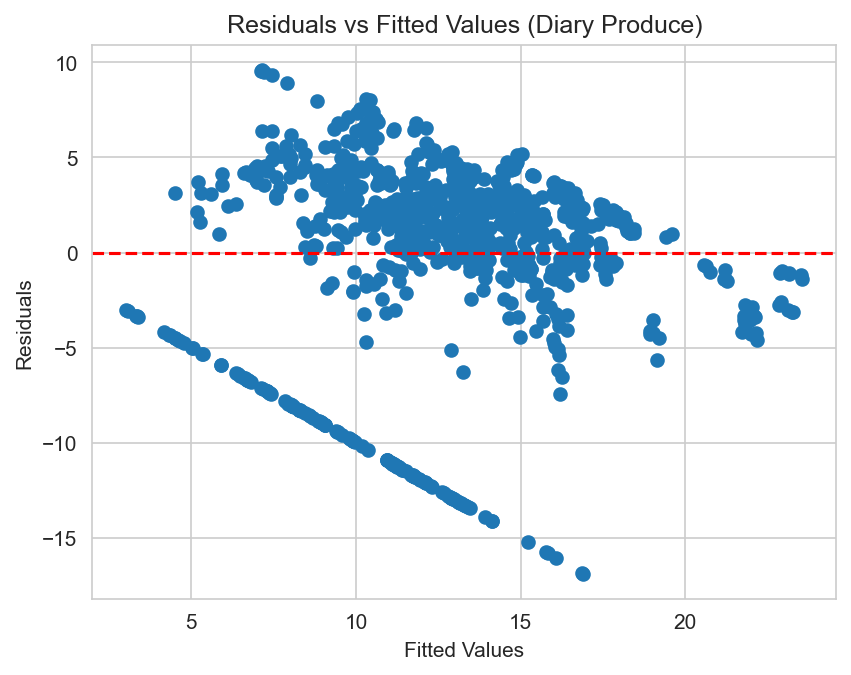

In [49]:
# feature = ['GDP', 'vacc_rate', 'freight', 'inflation', 'death_rate']
# target = 'dairy_produce'
# scatter_plot = sns.pairplot(final_data, x_vars=feature, y_vars=target, kind='scatter')
# scatter_plot.fig.set_size_inches(30, 6)
# plt.show()

plt.scatter(model_diary.fittedvalues, model_diary.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Diary Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

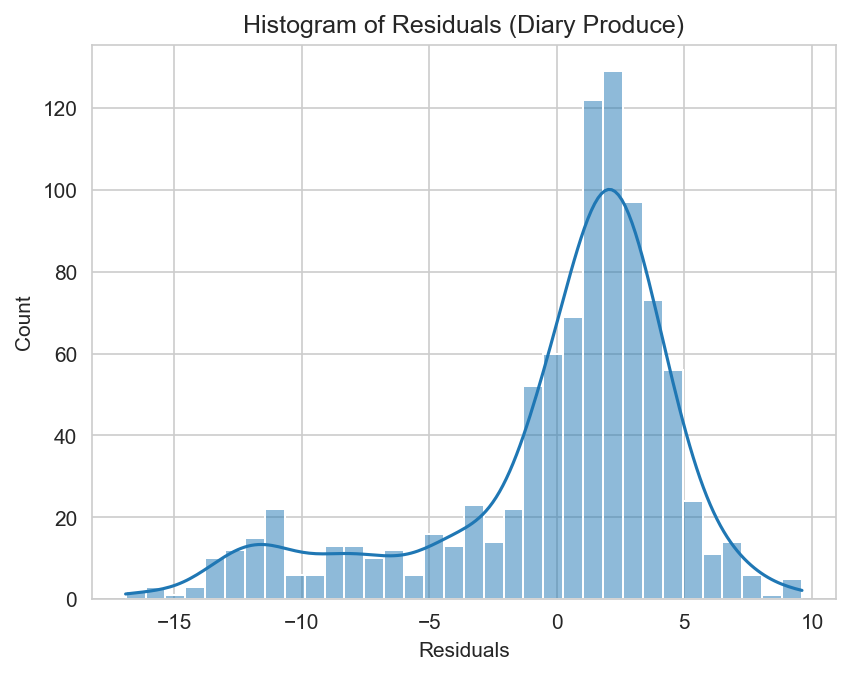

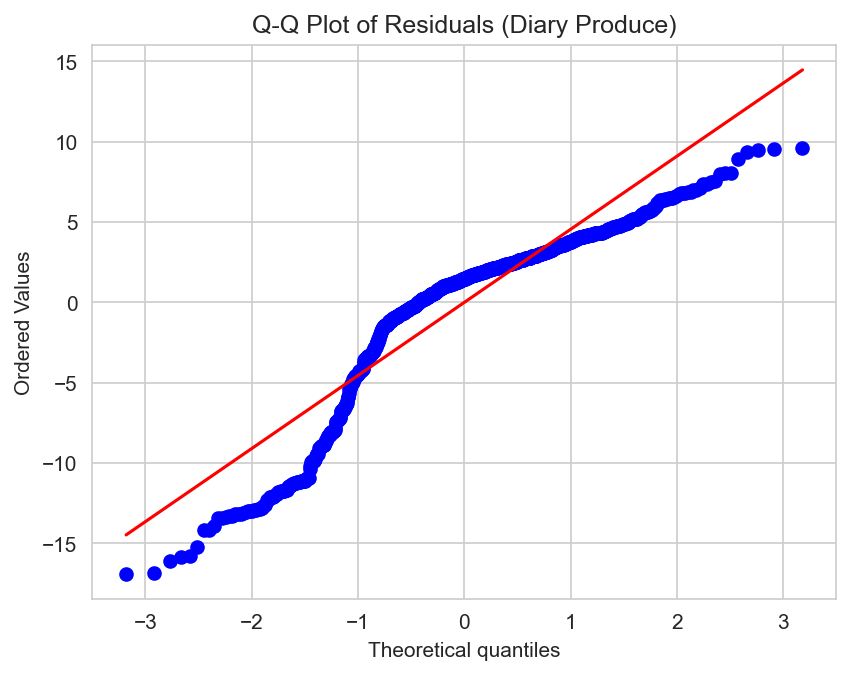

In [50]:
# standard residuals
sns.histplot(model_diary.resid, kde=True)
plt.title('Histogram of Residuals (Diary Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_diary.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Diary Produce)')
plt.show()

### Aquatic produce

In [51]:
y = final_data['aquatic_produce']
scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_aquatic = sm.OLS(y_ols, X_ols).fit()
model_aquatic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     37.01
Date:                Tue, 27 Aug 2024   Prob (F-statistic):           1.40e-79
Time:                        16:45:30   Log-Likelihood:                -2940.0
No. Observations:                 941   AIC:                             5910.
Df Residuals:                     926   BIC:                             5983.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.2497      0.181     45.615      0.000       7.895       8.605
GDP                3.0558      0.250     12.232      0.000       2.566       3.546
avg_GDP            1.0121      0.252      4.015      0.000       0.517       1.507
vacc_rate         -0.2075      0.197     -1.055      0.292      -0.594       0.179
freight           -0.3241      0.191     -1.698      0.090      -0.699       0.051
inflation         -0.2748      0.186     -1.475      0.141      -0.640       0.091
death_rate        -0.2344      0.185     -1.270      0.204      -0.597       0.128
FTA                1.3355      0.287      4.648      0.000       0.772       1.899
Asia              -0.5116      0.149     -3.438      0.001      -0.804      -0.220
Africa             0.4539      0.180      2.518      0.012       0.100       0.808
North_America     -1.3964      0.166     -8.408      0.000      -1.722      -1.070
South_America     -0.6413      0.173     -3.711      0.000      -0.980      -0.302
Europe             0.0864      0.178      0.485      0.627      -0.263       0.436
Oceania            2.0892      0.199     10.507      0.000       1.699       2.479
pandemic           0.0484      0.199      0.243      0.808      -0.342       0.439
pandemic * FTA    -0.1381      0.283     -0.487      0.626      -0.694       0.418
==============================================================================
Omnibus:                       76.059   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.623
Skew:                          -0.349   Prob(JB):                     1.51e-09
Kurtosis:                       2.259   Cond. No.                     2.77e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.91e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Hypothesis test check whether linear regression works (Diary Produce)
##### 1. Linearity and  Homoscedasticity (residual plot)

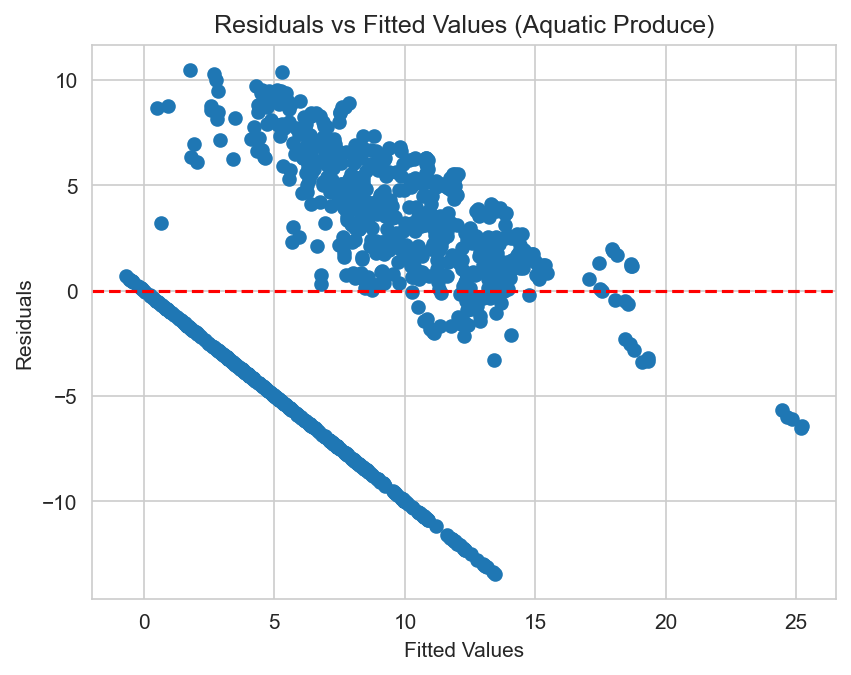

In [52]:
plt.scatter(model_aquatic.fittedvalues, model_aquatic.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Aquatic Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

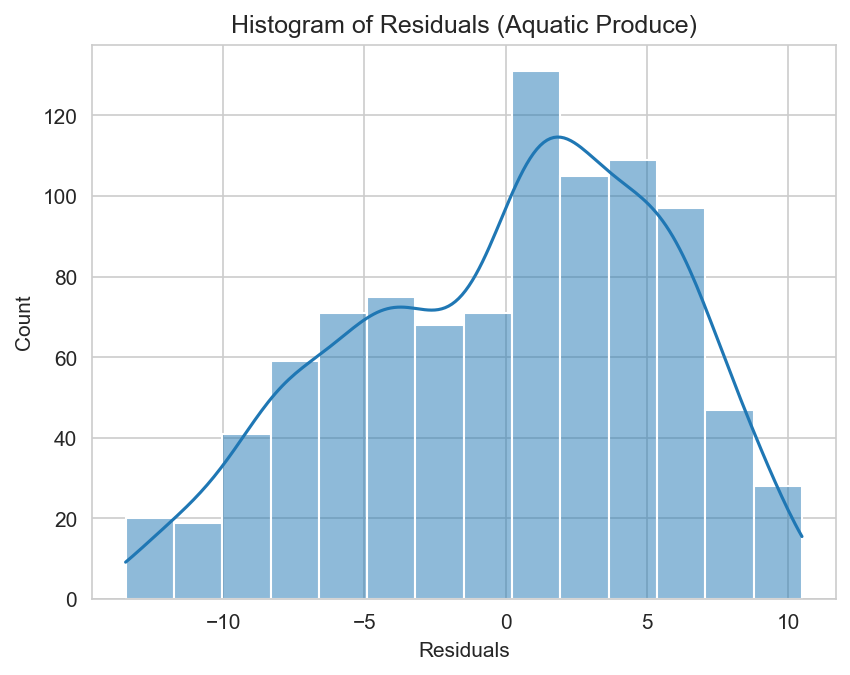

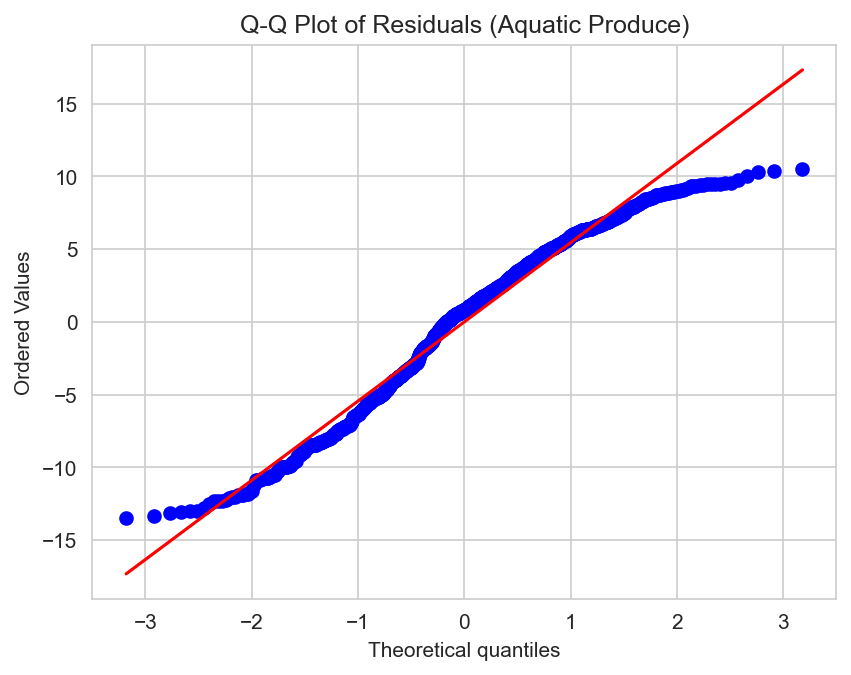

In [53]:
# standard residuals
sns.histplot(model_aquatic.resid, kde=True)
plt.title('Histogram of Residuals (Aquatic Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_aquatic.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Aquatic Produce)')
plt.show()

### Fruit produce

In [54]:
y = final_data['fruit_produce']
scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_fruit = sm.OLS(y_ols, X_ols).fit()
model_fruit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     65.83
Date:                Tue, 27 Aug 2024   Prob (F-statistic):          2.79e-128
Time:                        16:45:31   Log-Likelihood:                -2856.6
No. Observations:                 941   AIC:                             5743.
Df Residuals:                     926   BIC:                             5816.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              6.0318      0.166     36.442      0.000       5.707       6.357
GDP                3.2043      0.229     14.014      0.000       2.756       3.653
avg_GDP            1.6311      0.231      7.071      0.000       1.178       2.084
vacc_rate          0.2046      0.180      1.136      0.256      -0.149       0.558
freight           -0.1960      0.175     -1.122      0.262      -0.539       0.147
inflation         -0.5933      0.171     -3.480      0.001      -0.928      -0.259
death_rate        -0.2928      0.169     -1.734      0.083      -0.624       0.039
FTA                1.1119      0.263      4.229      0.000       0.596       1.628
Asia               0.9516      0.136      6.987      0.000       0.684       1.219
Africa            -0.6309      0.165     -3.824      0.000      -0.955      -0.307
North_America     -0.3732      0.152     -2.455      0.014      -0.671      -0.075
South_America     -1.2016      0.158     -7.599      0.000      -1.512      -0.891
Europe            -1.3891      0.163     -8.528      0.000      -1.709      -1.069
Oceania            2.7611      0.182     15.174      0.000       2.404       3.118
pandemic          -0.0057      0.182     -0.031      0.975      -0.363       0.351
pandemic * FTA     0.0516      0.259      0.199      0.842      -0.457       0.561
==============================================================================
Omnibus:                       35.451   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.445
Skew:                           0.148   Prob(JB):                     9.88e-05
Kurtosis:                       2.381   Cond. No.                     2.77e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.91e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Hypothesis test check whether linear regression works (Fruit Produce)
##### 1. Linearity and  Homoscedasticity (residual plot)

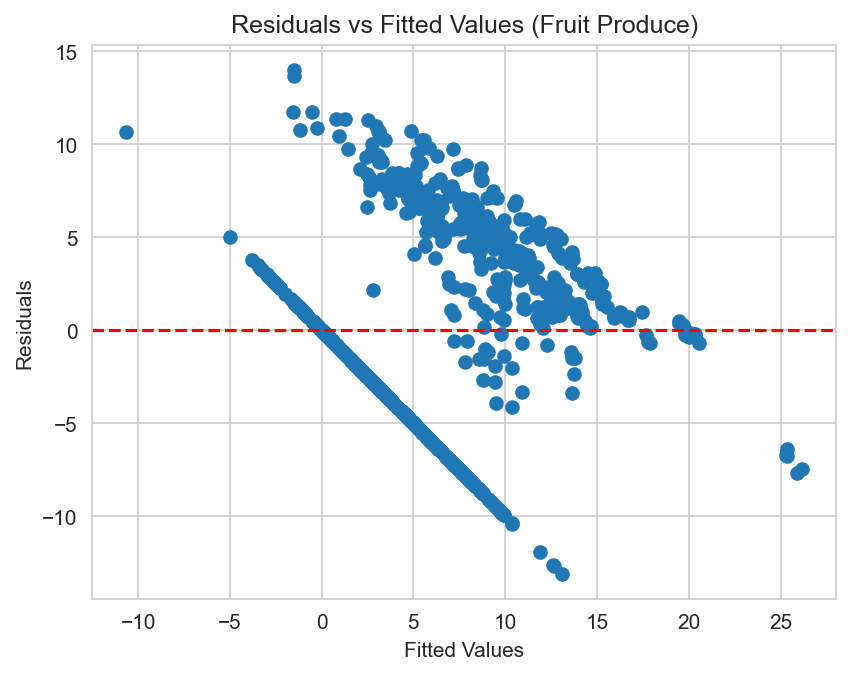

In [55]:
plt.scatter(model_fruit.fittedvalues, model_fruit.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Fruit Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

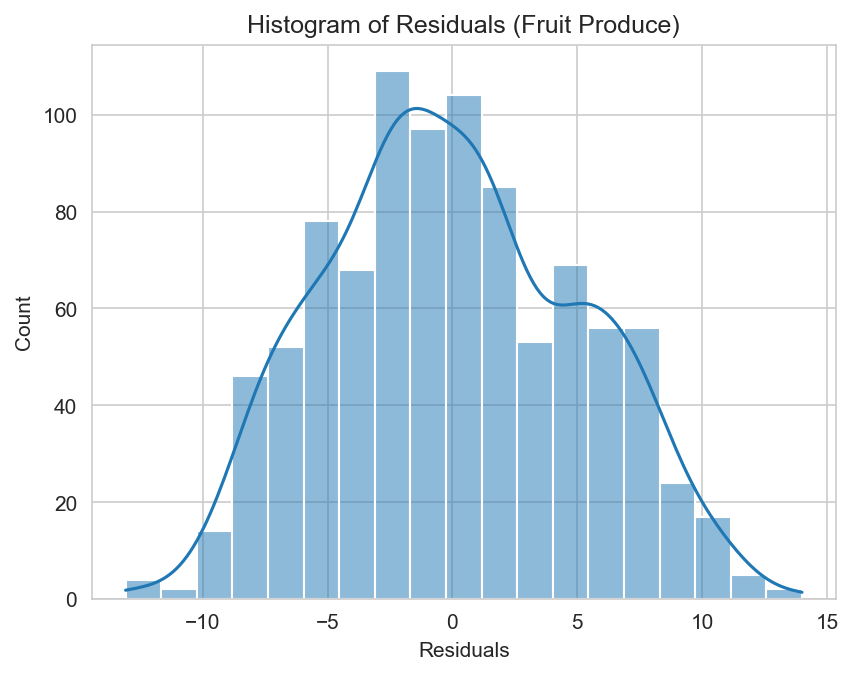

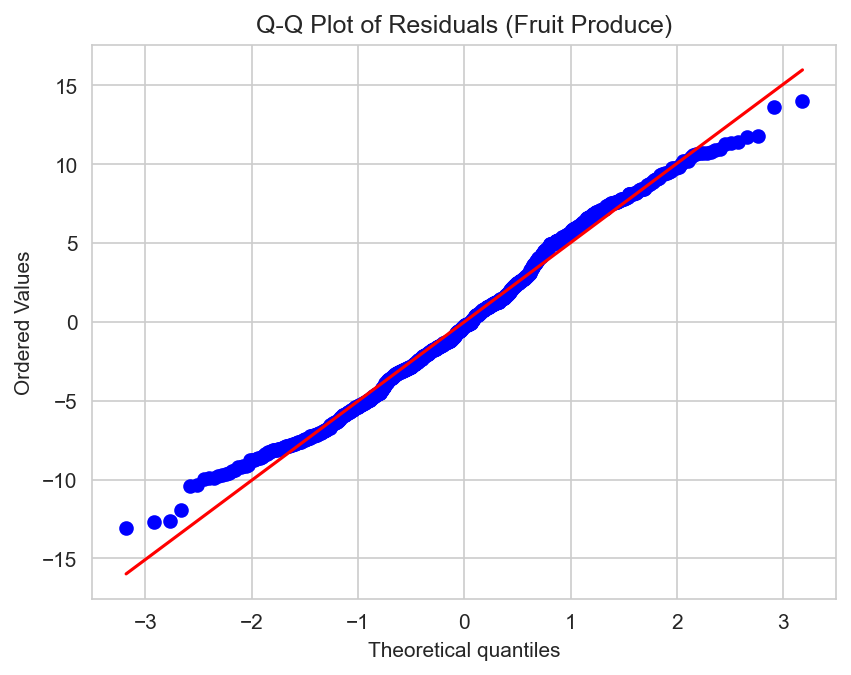

In [56]:
# standard residuals
sns.histplot(model_fruit.resid, kde=True)
plt.title('Histogram of Residuals (Fruit Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_fruit.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Fruit Produce)')
plt.show()

### Meat Produce

In [57]:
y = final_data['meat_produce']
scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_meat = sm.OLS(y_ols, X_ols).fit()
model_meat.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     59.39
Date:                Tue, 27 Aug 2024   Prob (F-statistic):          2.31e-118
Time:                        16:45:31   Log-Likelihood:                -2952.0
No. Observations:                 941   AIC:                             5934.
Df Residuals:                     926   BIC:                             6007.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              7.9871      0.183     43.601      0.000       7.628       8.347
GDP                2.7776      0.253     10.977      0.000       2.281       3.274
avg_GDP            2.8550      0.255     11.183      0.000       2.354       3.356
vacc_rate         -0.1772      0.199     -0.889      0.374      -0.568       0.214
freight           -0.7934      0.193     -4.104      0.000      -1.173      -0.414
inflation          0.0351      0.189      0.186      0.853      -0.335       0.405
death_rate        -0.3567      0.187     -1.908      0.057      -0.723       0.010
FTA                0.7106      0.291      2.442      0.015       0.140       1.282
Asia               0.0904      0.151      0.600      0.549      -0.205       0.386
Africa            -0.2912      0.183     -1.595      0.111      -0.650       0.067
North_America     -0.5849      0.168     -3.477      0.001      -0.915      -0.255
South_America     -1.9574      0.175    -11.184      0.000      -2.301      -1.614
Europe            -0.1550      0.180     -0.860      0.390      -0.509       0.199
Oceania            2.6035      0.201     12.928      0.000       2.208       2.999
pandemic          -0.1040      0.201     -0.517      0.606      -0.499       0.291
pandemic * FTA     0.3232      0.287      1.126      0.260      -0.240       0.887
==============================================================================
Omnibus:                       19.569   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.228
Skew:                          -0.193   Prob(JB):                     0.000814
Kurtosis:                       2.538   Cond. No.                     2.77e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.91e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Hypothesis test check whether linear regression works (Meat Produce)
##### 1. Linearity and  Homoscedasticity (residual plot)

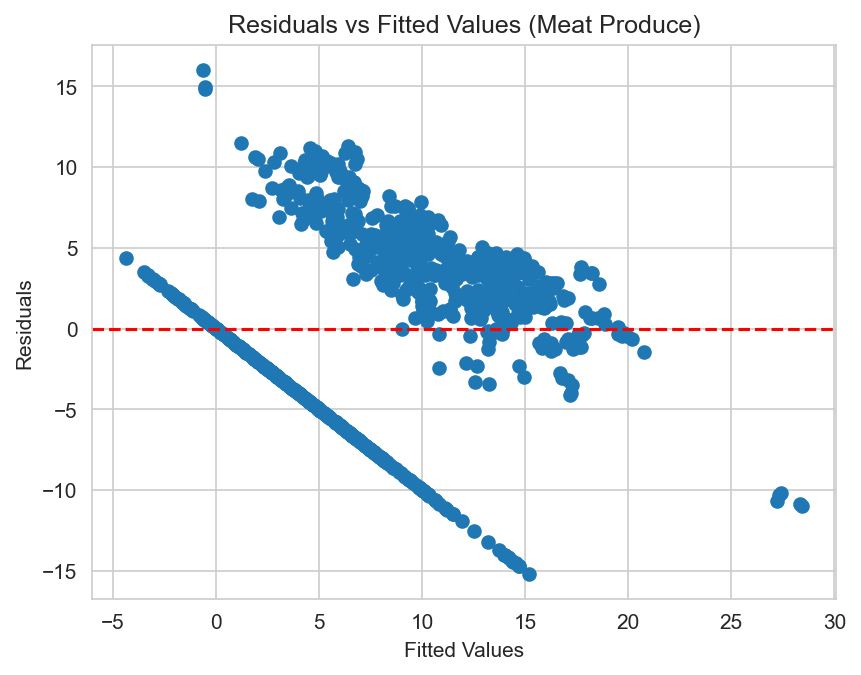

In [58]:
plt.scatter(model_meat.fittedvalues, model_meat.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Meat Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

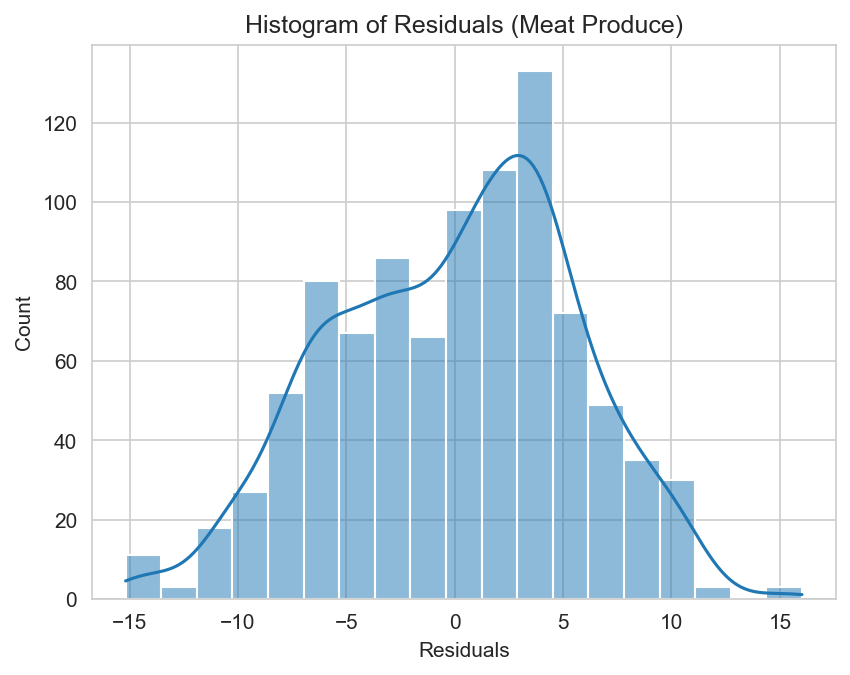

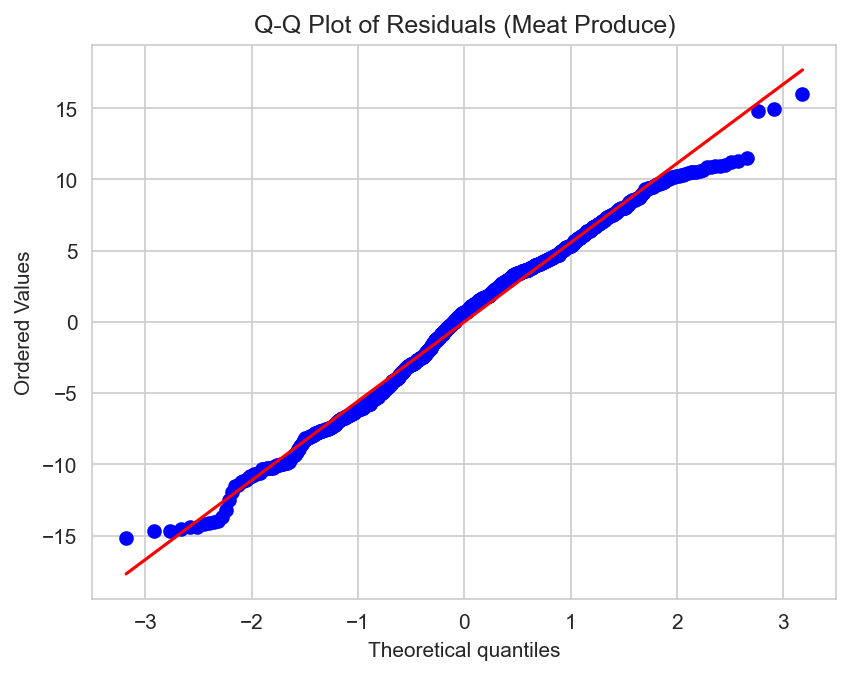

In [59]:
# standard residuals
sns.histplot(model_meat.resid, kde=True)
plt.title('Histogram of Residuals (Meat Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_meat.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Meat Produce)')
plt.show()

### Vegetable Produce

In [60]:
y = final_data['vegetable_produce']
scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_vegetable = sm.OLS(y_ols, X_ols).fit()
model_vegetable.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     95.68
Date:                Tue, 27 Aug 2024   Prob (F-statistic):          7.77e-169
Time:                        16:45:32   Log-Likelihood:                -2701.4
No. Observations:                 941   AIC:                             5433.
Df Residuals:                     926   BIC:                             5505.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              5.5970      0.140     39.879      0.000       5.322       5.872
GDP                3.5161      0.194     18.135      0.000       3.136       3.897
avg_GDP            1.5202      0.196      7.772      0.000       1.136       1.904
vacc_rate         -0.2038      0.153     -1.335      0.182      -0.503       0.096
freight           -0.6342      0.148     -4.281      0.000      -0.925      -0.344
inflation          0.0979      0.145      0.677      0.499      -0.186       0.382
death_rate        -0.4179      0.143     -2.918      0.004      -0.699      -0.137
FTA                1.0643      0.223      4.773      0.000       0.627       1.502
Asia               0.5086      0.115      4.404      0.000       0.282       0.735
Africa            -0.2347      0.140     -1.678      0.094      -0.509       0.040
North_America     -1.3761      0.129    -10.677      0.000      -1.629      -1.123
South_America     -0.5158      0.134     -3.847      0.000      -0.779      -0.253
Europe            -1.3378      0.138     -9.685      0.000      -1.609      -1.067
Oceania            3.4473      0.154     22.342      0.000       3.145       3.750
pandemic           0.1717      0.154      1.113      0.266      -0.131       0.475
pandemic * FTA     0.0963      0.220      0.438      0.662      -0.335       0.528
==============================================================================
Omnibus:                        1.472   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.479   Jarque-Bera (JB):                1.529
Skew:                          -0.067   Prob(JB):                        0.466
Kurtosis:                       2.855   Cond. No.                     2.77e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.91e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Hypothesis test check whether linear regression works (Vegetable Produce)
##### 1. Linearity and  Homoscedasticity (residual plot)

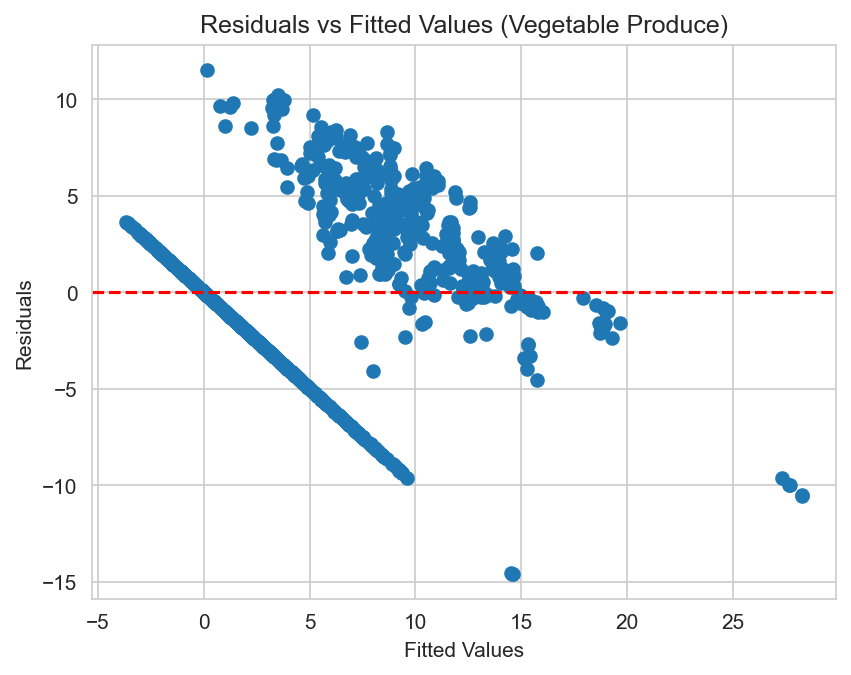

In [61]:
plt.scatter(model_vegetable.fittedvalues, model_vegetable.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (Vegetable Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

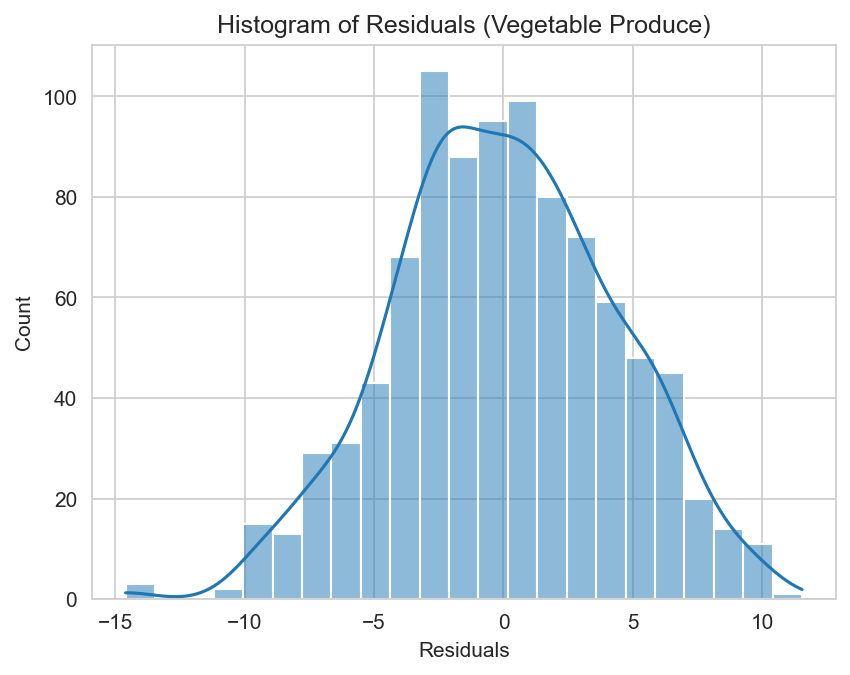

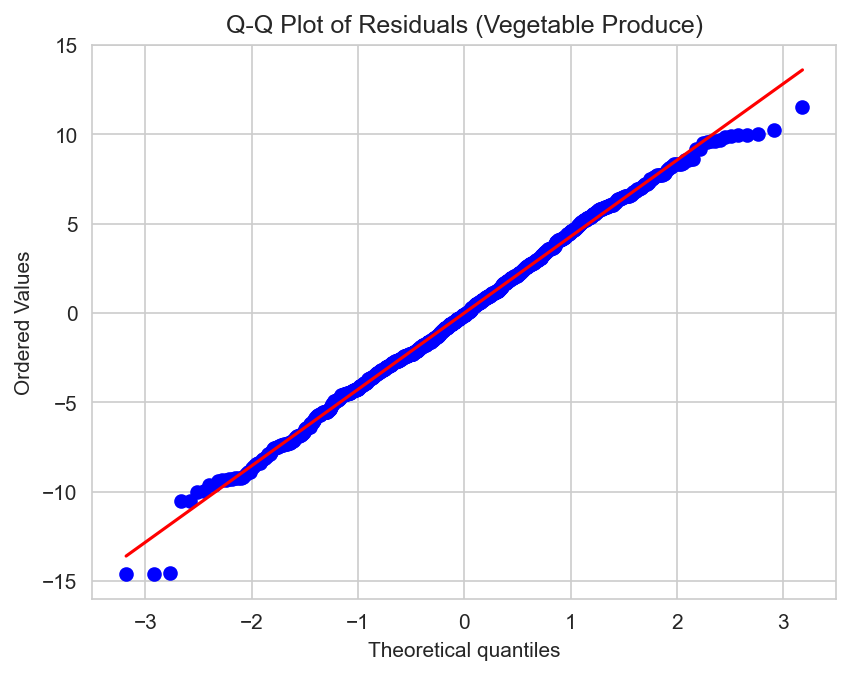

In [62]:
# standard residuals
sns.histplot(model_vegetable.resid, kde=True)
plt.title('Histogram of Residuals (Vegetable Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_vegetable.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Vegetable Produce)')
plt.show()

### All trade

In [63]:
y = final_data['all_trade']
scaler = StandardScaler()
X_standard = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_ols = sm.add_constant(X_standard)
y_ols = list(y)
model_all = sm.OLS(y_ols, X_ols).fit()
model_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     76.38
Date:                Tue, 27 Aug 2024   Prob (F-statistic):          1.47e-143
Time:                        16:45:33   Log-Likelihood:                -1905.6
No. Observations:                 941   AIC:                             3841.
Df Residuals:                     926   BIC:                             3914.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             15.5160      0.060    257.541      0.000      15.398      15.634
GDP                2.0392      0.083     24.503      0.000       1.876       2.203
avg_GDP            0.3661      0.084      4.360      0.000       0.201       0.531
vacc_rate         -0.0549      0.066     -0.837      0.403      -0.184       0.074
freight            0.1618      0.064      2.545      0.011       0.037       0.287
inflation          0.0183      0.062      0.294      0.769      -0.104       0.140
death_rate        -0.0661      0.061     -1.076      0.282      -0.187       0.054
FTA                0.3665      0.096      3.829      0.000       0.179       0.554
Asia               0.1757      0.050      3.544      0.000       0.078       0.273
Africa             0.1451      0.060      2.416      0.016       0.027       0.263
North_America      0.2601      0.055      4.701      0.000       0.152       0.369
South_America     -0.4040      0.058     -7.019      0.000      -0.517      -0.291
Europe            -0.8386      0.059    -14.144      0.000      -0.955      -0.722
Oceania            0.6964      0.066     10.515      0.000       0.566       0.826
pandemic          -0.0400      0.066     -0.604      0.546      -0.170       0.090
pandemic * FTA     0.0351      0.094      0.372      0.710      -0.150       0.220
==============================================================================
Omnibus:                       99.761   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.271
Skew:                          -0.770   Prob(JB):                     1.73e-32
Kurtosis:                       4.166   Cond. No.                     2.77e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.91e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### Hypothesis test check whether linear regression works (Fruit Produce)
##### 1. Linearity and  Homoscedasticity (residual plot)

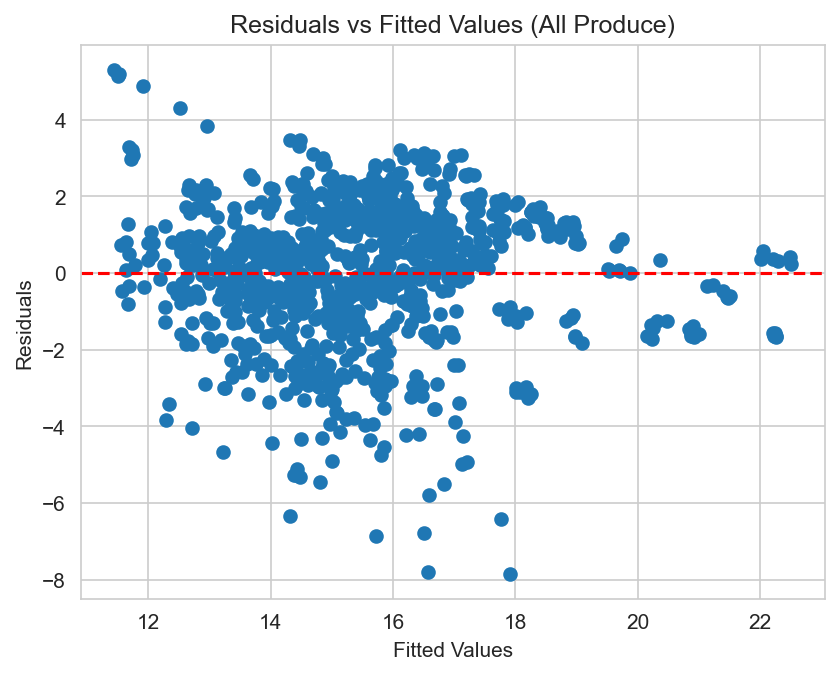

In [64]:
plt.scatter(model_all.fittedvalues, model_all.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values (All Produce)')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

##### 2. Normality of Errors (Histogram of Residuals and Q-Q plot)

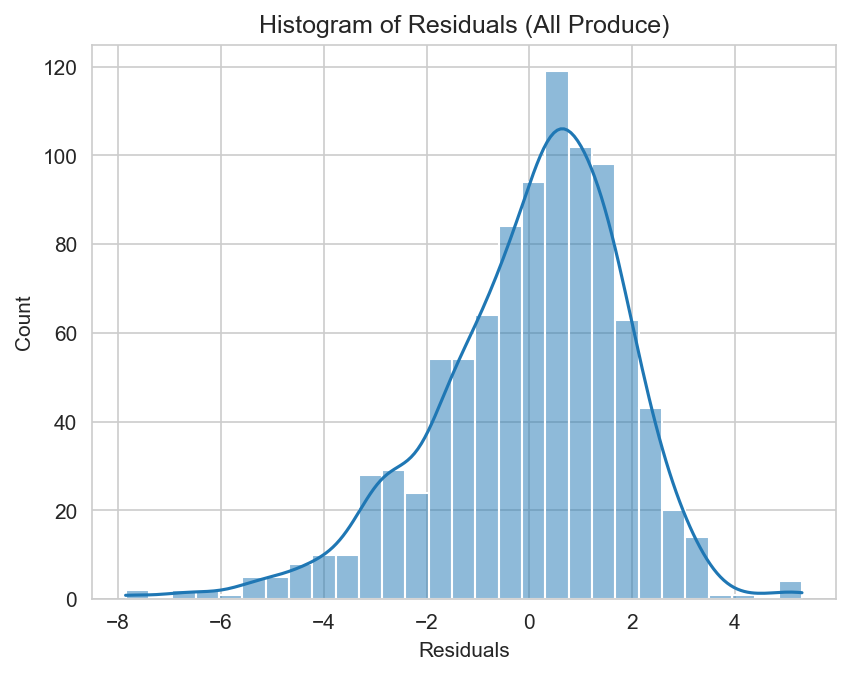

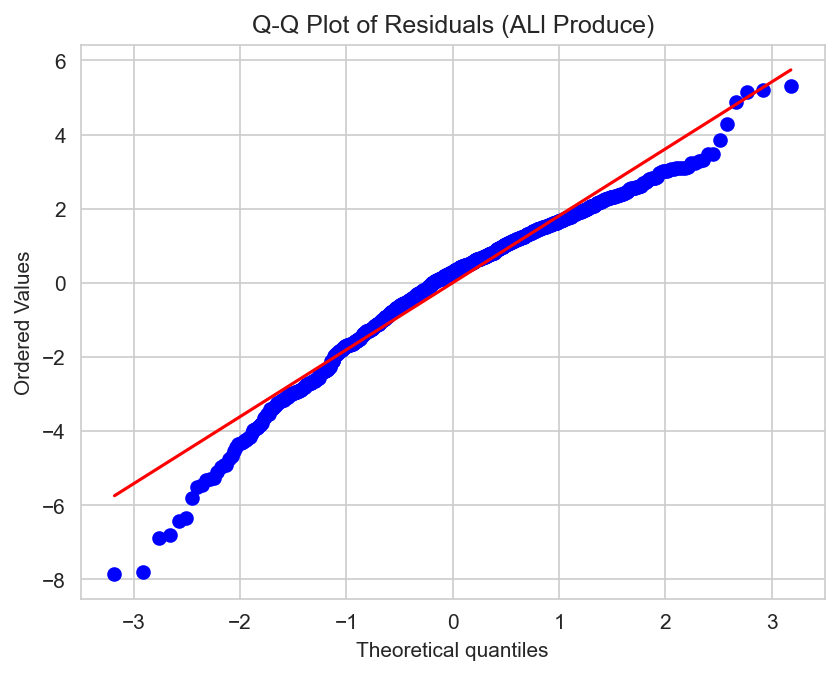

In [65]:
# standard residuals
sns.histplot(model_all.resid, kde=True)
plt.title('Histogram of Residuals (All Produce)')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot
stats.probplot(model_all.resid, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (ALl Produce)')
plt.show()

### 1. What factors affect New Zealand's food exports? And how?

#### For Diary produce:

New Zealand's Diary exports are positively influenced by GDP, participation in Free Trade Agreements (FTAs), and strong trade relations with regions like Asia, North America, and Oceania. Freight costs also show a positive impact, which could reflect efficient trade logistics or high-value exports.

On the other hand, negative factors include average GDP, vaccination rates, and death rates, suggesting that these socio-economic indicators may present challenges to export performance. Exports to South America and Europe also negatively impact food exports, indicating potential difficulties in these markets, such as competition or market access issues.

Regarding the pandemic, the overall impact appears to be slightly negative, but the interaction with FTAs shows that these agreements may have helped mitigate some of the adverse effects, albeit to a small extent. This highlights the importance of economic growth, trade agreements, and regional market conditions in sustaining New Zealand's food export performance, particularly during global disruptions like the pandemic.


#### For Aquatic produce:
New Zealand's food exports benefit from strong economic factors such as GDP and average GDP, along with positive effects from trade agreements like FTAs. Additionally, regions like Africa and Oceania show a positive impact on food exports, highlighting favorable market conditions in these areas.

However, several factors negatively impact food exports, including vaccination rates, freight costs, inflation, and death rates. These economic and logistical challenges likely hinder export performance. Additionally, regions such as Asia, North America, and South America pose significant challenges, possibly due to competition, market access issues, or other region-specific barriers.

The effects of the pandemic on food exports appear to be slightly positive, but the interaction with FTAs indicates that these agreements has negative effects on the outputs. This underscores the need for robust strategies to enhance the resilience of New Zealand’s export sector during global crises.


#### For Fruit produce:
New Zealand's fruit exports are positively influenced by strong economic factors such as GDP, average GDP, and participation in Free Trade Agreements (FTAs). Additionally, regions like Asia and Oceania show positive effects, reflecting strong demand and favorable trade conditions in these markets.

Conversely, several factors negatively impact food exports. Higher freight costs, inflation, and death rates are detrimental to export performance, likely due to increased costs and economic disruptions. Furthermore, regions like Africa, North America, South America, and Europe show negative impacts, suggesting significant challenges in these markets, such as competition, logistical barriers, or economic instability.

The effects of the pandemic on food exports appear to be slightly negative, but the interaction with FTAs indicates that these agreements may have provided some support, helping to mitigate the pandemic’s adverse effects. Overall, the results highlight the importance of economic growth, trade agreements, and regional market conditions in sustaining and enhancing New Zealand's food export performance, even in the face of global disruptions like the pandemic.


#### For Meat produce:
New Zealand's meat exports benefit from strong economic indicators such as GDP and average GDP, along with participation in Free Trade Agreements (FTAs). The Oceania region is also a significant positive contributor to export performance, reflecting the advantages of geographical proximity and established trade networks.

However, several factors negatively influence food exports. High freight costs and increased death rates have a detrimental effect, possibly due to the associated costs and disruptions. Exports to Africa, North America, South America, and Europe also show negative impacts, indicating challenges such as competition, market access, or logistical difficulties in these regions.

Additionally, the pandemic itself negatively affects food exports, exacerbating the challenges faced by New Zealand's export sector. While FTAs provide some support, the pandemic's impact underscores the need for adaptive strategies to mitigate disruptions and leverage trade agreements effectively during global crises.


#### For Vegetable produce:
New Zealand's vegetable exports are positively influenced by strong economic performance indicators such as GDP and average GDP, as well as participation in Free Trade Agreements (FTAs). The Asian and Oceania markets also significantly boost food exports, reflecting strong demand and favorable trade conditions in these regions.

However, several factors negatively impact food exports, including higher freight costs, increased death rates, and challenges in regions like Africa, North America, South America, and Europe. These negative effects may stem from logistical issues, market competition, or economic disruptions in these areas.

Regarding the pandemic's impact, while the direct effect appears to be slightly positive, it is relatively minor. The interaction between the pandemic and FTAs shows a slight positive effect, indicating that FTAs may have provided some support during the pandemic, helping to cushion its impact on food exports. Overall, the results highlight the importance of economic growth, strategic trade agreements, and regional market conditions in determining the success of New Zealand's food exports, especially in times of global crisis.


#### For all trade produce:
The analysis shows that New Zealand's food exports benefit from strong economic performance indicators like GDP and average GDP, along with favorable conditions in regions such as Asia, Africa, North America, and Oceania. Participation in Free Trade Agreements (FTAs) and even freight costs are positively associated with higher food exports, which could reflect efficient trade logistics or high-value export markets.

On the other hand, the death rate, along with exports to South America and Europe, negatively impacts food exports. These regions may present specific challenges such as market access issues, competition, or economic instability.

The effects of the pandemic on food exports appear to be slightly negative, but the presence of FTAs might have provided some support, helping to buffer the pandemic's impact. Overall, the results highlight the importance of maintaining strong economic fundamentals and leveraging trade agreements to optimize New Zealand's food export performance, even during global disruptions.

### 2. Can Free Trade Agreement (FTA) help New Zealand export more food to its trade partners?

Yes, based on the linear regression model for all items, the coefficient for FTA in every situation is positive, which means FTA help New Zealand export more food to its trade partners 

### 3. How has COVID-19 affected New Zealand exports? (e.g. overall vs. each export item) (Combine the analysis in Q1 also)

The covid looks like is not a significant variable (p-value is large, also LASSO regression will show it is not a significant variable)

But just using coefficient:
* For Dairy produce: negative effect
* For Aquatic produce: positive effect
* For Fruit produce: negative effect
* For Meat produce: negative effect
* For Vegetable produce: positive effect
* for all trade: negative effect

If also consider death rate of COVID-19, we can find that for all output items, the death rate (COVID-19) has negative effect for the New Zealand food exports 

But all effect is really small and can be ignored

### 4. Can FTA offset the negative effect of COVID-19 on New Zealand exports? Or Can FTA boost the positive effect of COVID-19 on New Zealand exports? If so, how?

### All trade data

In [66]:
final_data.columns

Index(['year', 'country', 'dairy_produce', 'aquatic_produce', 'fruit_produce',
       'meat_produce', 'vegetable_produce', 'all_trade', 'GDP', 'avg_GDP',
       'vacc_rate', 'freight', 'inflation', 'death_rate', 'FTA', 'Asia',
       'Africa', 'North_America', 'South_America', 'Europe', 'Oceania',
       'pandemic', 'pandemic * FTA'],
      dtype='object')

In [67]:
model_formula = 'all_trade ~ FTA + pandemic + pandemic * FTA + GDP + avg_GDP + vacc_rate + freight + inflation + death_rate + Oceania + Asia + Africa + North_America + South_America + Europe'
model = smf.ols(formula=model_formula, data=final_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              all_trade   R-squared:                       0.536
Model:                            OLS   Adj. R-squared:                  0.529
Method:                 Least Squares   F-statistic:                     76.38
Date:                Tue, 27 Aug 2024   Prob (F-statistic):          1.47e-143
Time:                        16:45:34   Log-Likelihood:                -1905.6
No. Observations:                 941   AIC:                             3841.
Df Residuals:                     926   BIC:                             3914.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -7.1895      0.788     -9.127      0.000      -8.735      -5.644
FTA               1.1545      0.301      3.829      0.000       0.563       1.746
pandemic         -0.0800      0.132     -0.604      0.546      -0.340       0.180
pandemic:FTA      0.1436      0.386      0.372      0.710      -0.615       0.902
GDP               0.8645      0.035     24.503      0.000       0.795       0.934
avg_GDP           0.2675      0.061      4.360      0.000       0.147       0.388
vacc_rate        -0.0016      0.002     -0.837      0.403      -0.005       0.002
freight           0.0108      0.004      2.545      0.011       0.002       0.019
inflation         0.0010      0.003      0.294      0.769      -0.006       0.008
death_rate       -1.9605      1.822     -1.076      0.282      -5.536       1.615
Oceania           1.0795      0.187      5.763      0.000       0.712       1.447
Asia             -0.7758      0.203     -3.825      0.000      -1.174      -0.378
Africa           -0.8419      0.177     -4.755      0.000      -1.189      -0.494
North_America    -0.4720      0.191     -2.477      0.013      -0.846      -0.098
South_America    -2.9915      0.286    -10.465      0.000      -3.553      -2.431
Europe           -3.1877      0.249    -12.827      0.000      -3.675      -2.700
==============================================================================
Omnibus:                       99.761   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.271
Skew:                          -0.770   Prob(JB):                     1.73e-32
Kurtosis:                       4.166   Cond. No.                     1.61e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.5e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### FTA offset the negative effect, the FTA * pandemic indicates FTAs can indeed mitigate the negative impacts of COVID-19 on all exports

### Diary

In [68]:
model_formula = 'dairy_produce ~ FTA + pandemic + pandemic * FTA + GDP + avg_GDP + vacc_rate + freight + inflation + death_rate + Oceania + Asia + Africa + North_America + South_America + Europe'
model = smf.ols(formula=model_formula, data=final_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          dairy_produce   R-squared:                       0.346
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     35.01
Date:                Tue, 27 Aug 2024   Prob (F-statistic):           9.37e-76
Time:                        16:45:34   Log-Likelihood:                -2828.4
No. Observations:                 941   AIC:                             5687.
Df Residuals:                     926   BIC:                             5759.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -15.2424      2.100     -7.258      0.000     -19.364     -11.121
FTA               1.6030      0.804      1.994      0.046       0.026       3.181
pandemic         -0.1420      0.353     -0.402      0.688      -0.835       0.551
pandemic:FTA      0.1179      1.030      0.114      0.909      -1.904       2.140
GDP               1.2897      0.094     13.710      0.000       1.105       1.474
avg_GDP          -0.1549      0.164     -0.947      0.344      -0.476       0.166
vacc_rate        -0.0058      0.005     -1.122      0.262      -0.016       0.004
freight           0.0326      0.011      2.884      0.004       0.010       0.055
inflation         0.0040      0.009      0.446      0.656      -0.014       0.022
death_rate       -1.7139      4.857     -0.353      0.724     -11.246       7.819
Oceania           2.2450      0.499      4.495      0.000       1.265       3.225
Asia             -1.6738      0.541     -3.095      0.002      -2.735      -0.612
Africa           -2.7993      0.472     -5.930      0.000      -3.726      -1.873
North_America     0.6938      0.508      1.366      0.172      -0.303       1.691
South_America    -5.0891      0.762     -6.678      0.000      -6.585      -3.593
Europe           -8.6190      0.663    -13.008      0.000      -9.919      -7.319
==============================================================================
Omnibus:                      196.984   Durbin-Watson:                   2.127
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              336.917
Skew:                          -1.325   Prob(JB):                     6.91e-74
Kurtosis:                       4.254   Cond. No.                     1.61e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.5e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### FTA offset the negative effect, the FTA * pandemic indicates FTAs can indeed mitigate the negative impacts of COVID-19 on diary exports

### Aquatic

In [69]:
model_formula = 'aquatic_produce ~ FTA + pandemic + pandemic * FTA + GDP + avg_GDP + vacc_rate + freight + inflation + death_rate + Oceania + Asia + Africa + North_America + South_America + Europe'
model = smf.ols(formula=model_formula, data=final_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        aquatic_produce   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     37.01
Date:                Tue, 27 Aug 2024   Prob (F-statistic):           1.40e-79
Time:                        16:45:34   Log-Likelihood:                -2940.0
No. Observations:                 941   AIC:                             5910.
Df Residuals:                     926   BIC:                             5983.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -25.6330      2.365    -10.841      0.000     -30.273     -20.993
FTA               4.2070      0.905      4.648      0.000       2.431       5.983
pandemic          0.0968      0.398      0.243      0.808      -0.684       0.877
pandemic:FTA     -0.5650      1.160     -0.487      0.626      -2.841       1.711
GDP               1.2955      0.106     12.232      0.000       1.088       1.503
avg_GDP           0.7395      0.184      4.015      0.000       0.378       1.101
vacc_rate        -0.0062      0.006     -1.055      0.292      -0.018       0.005
freight          -0.0216      0.013     -1.698      0.090      -0.047       0.003
inflation        -0.0149      0.010     -1.475      0.141      -0.035       0.005
death_rate       -6.9481      5.469     -1.270      0.204     -17.681       3.785
Oceania           2.5065      0.562      4.458      0.000       1.403       3.610
Asia             -5.5094      0.609     -9.047      0.000      -6.704      -4.314
Africa           -3.2124      0.532     -6.044      0.000      -4.256      -2.169
North_America    -8.1594      0.572    -14.265      0.000      -9.282      -7.037
South_America    -7.1616      0.858     -8.346      0.000      -8.846      -5.478
Europe           -4.0968      0.746     -5.491      0.000      -5.561      -2.633
==============================================================================
Omnibus:                       76.059   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.623
Skew:                          -0.349   Prob(JB):                     1.51e-09
Kurtosis:                       2.259   Cond. No.                     1.61e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.5e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### FTA did not boost the positive effect of COVID-19, the negative value of FTA * pandemic indicates FTAs reduces the positive effect of COVID-19 in aquatic output

### Fruit

In [70]:
model_formula = 'fruit_produce ~ FTA + pandemic + pandemic * FTA + GDP + avg_GDP + vacc_rate + freight + inflation + death_rate + Oceania + Asia + Africa + North_America + South_America + Europe'
model = smf.ols(formula=model_formula, data=final_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          fruit_produce   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                     65.83
Date:                Tue, 27 Aug 2024   Prob (F-statistic):          2.79e-128
Time:                        16:45:34   Log-Likelihood:                -2856.6
No. Observations:                 941   AIC:                             5743.
Df Residuals:                     926   BIC:                             5816.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -32.6278      2.164    -15.077      0.000     -36.875     -28.381
FTA               3.5026      0.828      4.229      0.000       1.877       5.128
pandemic         -0.0113      0.364     -0.031      0.975      -0.726       0.703
pandemic:FTA      0.2111      1.062      0.199      0.842      -1.872       2.294
GDP               1.3585      0.097     14.014      0.000       1.168       1.549
avg_GDP           1.1918      0.169      7.071      0.000       0.861       1.523
vacc_rate         0.0061      0.005      1.136      0.256      -0.004       0.017
freight          -0.0131      0.012     -1.122      0.262      -0.036       0.010
inflation        -0.0322      0.009     -3.480      0.001      -0.050      -0.014
death_rate       -8.6790      5.005     -1.734      0.083     -18.502       1.144
Oceania           3.5558      0.515      6.910      0.000       2.546       4.566
Asia             -3.1986      0.557     -5.739      0.000      -4.292      -2.105
Africa           -6.9586      0.486    -14.305      0.000      -7.913      -6.004
North_America    -6.4742      0.523    -12.367      0.000      -7.502      -5.447
South_America   -10.8003      0.785    -13.753      0.000     -12.342      -9.259
Europe           -8.7520      0.683    -12.818      0.000     -10.092      -7.412
==============================================================================
Omnibus:                       35.451   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.445
Skew:                           0.148   Prob(JB):                     9.88e-05
Kurtosis:                       2.381   Cond. No.                     1.61e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.5e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### FTA offset the negative effect, the FTA * pandemic indicates FTAs can indeed mitigate the negative impacts of COVID-19 on Fruit exports

### Meat

In [71]:
model_formula = 'meat_produce ~ FTA + pandemic + pandemic * FTA + GDP + avg_GDP + vacc_rate + freight + inflation + death_rate + Oceania + Asia + Africa + North_America + South_America + Europe'
model = smf.ols(formula=model_formula, data=final_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           meat_produce   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     59.39
Date:                Tue, 27 Aug 2024   Prob (F-statistic):          2.31e-118
Time:                        16:45:34   Log-Likelihood:                -2952.0
No. Observations:                 941   AIC:                             5934.
Df Residuals:                     926   BIC:                             6007.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -33.5399      2.395    -14.004      0.000     -38.240     -28.840
FTA               2.2385      0.917      2.442      0.015       0.440       4.038
pandemic         -0.2080      0.403     -0.517      0.606      -0.999       0.582
pandemic:FTA      1.3229      1.175      1.126      0.260      -0.983       3.629
GDP               1.1776      0.107     10.977      0.000       0.967       1.388
avg_GDP           2.0861      0.187     11.183      0.000       1.720       2.452
vacc_rate        -0.0053      0.006     -0.889      0.374      -0.017       0.006
freight          -0.0530      0.013     -4.104      0.000      -0.078      -0.028
inflation         0.0019      0.010      0.186      0.853      -0.018       0.022
death_rate      -10.5708      5.539     -1.908      0.057     -21.442       0.300
Oceania           3.3475      0.570      5.877      0.000       2.230       4.465
Asia             -4.9247      0.617     -7.984      0.000      -6.135      -3.714
Africa           -5.8374      0.538    -10.843      0.000      -6.894      -4.781
North_America    -6.7535      0.579    -11.657      0.000      -7.891      -5.617
South_America   -13.8645      0.869    -15.952      0.000     -15.570     -12.159
Europe           -5.5072      0.756     -7.288      0.000      -6.990      -4.024
==============================================================================
Omnibus:                       19.569   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               14.228
Skew:                          -0.193   Prob(JB):                     0.000814
Kurtosis:                       2.538   Cond. No.                     1.61e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.5e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### FTA offset the negative effect, the FTA * pandemic indicates FTAs can indeed mitigate the negative impacts of COVID-19 on meat exports

### Vegetable

In [72]:
model_formula = 'vegetable_produce ~ FTA + pandemic + pandemic * FTA + GDP + avg_GDP + vacc_rate + freight + inflation + death_rate + Oceania + Asia + Africa + North_America + South_America + Europe'
model = smf.ols(formula=model_formula, data=final_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      vegetable_produce   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.585
Method:                 Least Squares   F-statistic:                     95.68
Date:                Tue, 27 Aug 2024   Prob (F-statistic):          7.77e-169
Time:                        16:45:34   Log-Likelihood:                -2701.4
No. Observations:                 941   AIC:                             5433.
Df Residuals:                     926   BIC:                             5505.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -34.2722      1.835    -18.677      0.000     -37.873     -30.671
FTA               3.3524      0.702      4.773      0.000       1.974       4.731
pandemic          0.3434      0.309      1.113      0.266      -0.262       0.949
pandemic:FTA      0.3942      0.900      0.438      0.662      -1.372       2.161
GDP               1.4906      0.082     18.135      0.000       1.329       1.652
avg_GDP           1.1108      0.143      7.772      0.000       0.830       1.391
vacc_rate        -0.0061      0.005     -1.335      0.182      -0.015       0.003
freight          -0.0423      0.010     -4.281      0.000      -0.062      -0.023
inflation         0.0053      0.008      0.677      0.499      -0.010       0.021
death_rate      -12.3847      4.244     -2.918      0.004     -20.714      -4.055
Oceania           5.0928      0.436     11.671      0.000       4.236       5.949
Asia             -4.9431      0.473    -10.460      0.000      -5.871      -4.016
Africa           -6.7066      0.412    -16.259      0.000      -7.516      -5.897
North_America    -9.9437      0.444    -22.401      0.000     -10.815      -9.073
South_America    -8.4424      0.666    -12.678      0.000      -9.749      -7.135
Europe           -9.3291      0.579    -16.114      0.000     -10.465      -8.193
==============================================================================
Omnibus:                        1.472   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.479   Jarque-Bera (JB):                1.529
Skew:                          -0.067   Prob(JB):                        0.466
Kurtosis:                       2.855   Cond. No.                     1.61e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.5e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### FTA boost the positive effect of COVID-19, both the positive value of pandemic and the FTA * pandemic indicates FTAs can indeed boost the positive impacts of COVID-19 on vegetable exports

$${Export\_item} = \alpha_0 + \alpha_1 \cdot {FTA} + \alpha_2 \cdot {pandemic} + \alpha_3 \cdot ({pandemic} \times {FTA}) + \alpha_4 \cdot \text{GDP} + \alpha_5 \cdot {avg\_GDP} + \alpha_6 \cdot {vacc\_rate} + \alpha_7 \cdot {freight} + \alpha_8 \cdot {inflation} + \alpha_9 \cdot {death\_rate} + \alpha_{10} \cdot {Oceania} + \alpha_{11} \cdot {Asia} + \alpha_{12} \cdot {Africa} + \alpha_{13} \cdot {North\_America} + \alpha_{14} \cdot {South\_America} + \alpha_{15} \cdot {Europe}$$